# Práctica  Escenarios de Estrés y Cambios de Régimen

## Objetivo
Construir un motor interpretable de detección de regímenes (calma/crisis) y simulación multiactivo con cópulas,
capaz de generar escenarios de estrés y cuantificar pérdidas extremas (VaR 99% y ES/CVaR 99%).



### Fase 1 — Detección de regímenes con Gaussian HMM (2 estados)
Modelizamos el “pulso” del mercado asumiendo que existen **dos regímenes latentes**: *calma* y *crisis*.
Para estimarlos, ajustamos un **Gaussian Hidden Markov Model (HMM)** con **2 estados** sobre una matriz de retornos diarios
(multiactivo), de forma que el modelo aprenda:

- La **distribución** de retornos típica en cada estado (media y covarianza).
- La **dinámica temporal** (probabilidad de permanecer en el estado o cambiar al otro).

Una vez entrenado, inferimos para cada día el estado más probable y lo **representamos sobre el S&P 500 (SPY)**,
coloreando el fondo: **Blanco = Calma**, **Azul = Crisis**.
#### Datos

Se explora el movimiento diario, desde 2006-01-01 hasta hoy, de los siguientes activos:
- High Yield: HYG
- Bonos gobierno USA 10Y y 2Y (proxies líquidos): IEF (7–10Y Treasury) y SHY (1–3Y Treasury)
- Mercado (proxy para gráficos/regímenes): SPY (S&P 500)
- Yields DGS10 y DGS2 (FRED) como indicadores de tipos

#### Fuentes:
- Precios ajustados (acciones/ETFs): Yahoo Finance (via `yfinance`)
- Series macro/crediticias (yields y spread HY): FRED (via `pandas_datareader`)

In [353]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as st
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from datetime import datetime, timezone
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler

En esta práctica se utilizan ETFs líquidos (por ejemplo, SPY, IEF, SHY, GLD y HYG) como proxies de los activos financieros subyacentes
(renta variable, bonos gubernamentales, oro y crédito high yield).
La elección responde a criterios de **liquidez y coherencia económica**.

Los ETFs proporcionan **precios diarios ajustados**, negociados en mercado continuo, lo que permite construir retornos homogéneos
y comparables entre activos desde 2006 sin problemas de iliquidez o falta de observaciones.
Esto es especialmente relevante en el caso de la renta fija, donde los bonos individuales no cotizan diariamente y presentan
problemas de precios “stale”.

Además, los ETFs reflejan de forma agregada el comportamiento de su clase de activo
(p. ej. SPY para el mercado accionario estadounidense o IEF/SHY para la curva de tipos),
lo que los hace adecuados para el análisis de **regímenes de mercado y escenarios de estrés**.
De este modo, se prioriza la estabilidad estadística del dataset y la interpretabilidad económica de los resultados.

In [354]:
# Tickers a usar
universe_tickers = [
    "GLD",
    "HYG",   # High Yield ETF (precio/retornos)
    "IEF",
    "SHY" # proxis líquidos para UST 10Y y 2Y (aprox.)
]

In [355]:
SEED = 42
np.random.seed(SEED)
FROM = "2006-01-01"
TO = datetime.now().date().isoformat()

Independientemente de los tickers elegidos, añadimos el S&P500 para poder utilizarlo como base en nuestras comparativas

In [356]:
universe_tickers.append("SPY") # mercado (S&P500)

In [357]:
# Series FRED (indicadores interpretables)
fred_series = {
    "DGS10": "UST_10Y_YIELD",          # 10Y yield
    "DGS2":  "UST_2Y_YIELD",           # 2Y yield
    "BAMLH0A0HYM2": "HY_OAS_SPREAD"    # spread HY
}

# Descargamos los datos desde la fuente de YFinances
universe_px = yf.download(
    universe_tickers,
    start=FROM,
    end=TO,
    auto_adjust=True,
    progress=False)["Close"]

# Leemos los datos la fred
fred = pdr.DataReader(list(fred_series.keys()), "fred", FROM, TO)
fred = fred.rename(columns=fred_series)

# Eliminamos los dias que no haya precio (no bursatil)
# Seran aquellos en los que no haya cotizacion para ninguno de los activos (fila entera con NaNs)
universe_px = universe_px.dropna(axis=0, how="all")
fred = fred.dropna(axis=0, how="all")

# Eliminamos los tickers que no tengan precio
universe_px = universe_px.dropna(axis=1, how="all")
fred = fred.dropna(axis=1, how="all")

# Calculamos los retornos
returns = np.log(universe_px).diff().dropna()
closed_prices = pd.concat([universe_px.add_prefix("PX_"), fred.add_prefix("FRED_")], axis=1)

print("Rango (Dias Bursatiles):", universe_px.index.min().date(), "-", universe_px.index.max().date())
print("Precios descargados:", universe_px.shape[1], "activos |", list(universe_px.columns))
print("FRED descargado:", fred.shape[1], "series |", list(fred.columns))
print("Retornos (log) shape:", returns.shape)
display(closed_prices)

Rango (Dias Bursatiles): 2006-01-03 - 2026-02-13
Precios descargados: 5 activos | ['GLD', 'HYG', 'IEF', 'SHY', 'SPY']
FRED descargado: 3 series | ['UST_10Y_YIELD', 'UST_2Y_YIELD', 'HY_OAS_SPREAD']
Retornos (log) shape: (4742, 5)


,PX_GLD,PX_HYG,PX_IEF,PX_SHY,PX_SPY,FRED_UST_10Y_YIELD,FRED_UST_2Y_YIELD,FRED_HY_OAS_SPREAD
2006-01-03,53.119999,NaN,49.726398,55.632381,87.463264,4.37,4.34,3.73
2006-01-04,53.299999,NaN,49.815292,55.687820,87.877434,4.36,4.31,3.69
2006-01-05,52.340000,NaN,49.827148,55.639313,87.932678,4.36,4.32,3.64
2006-01-06,53.720001,NaN,49.761967,55.653164,88.664406,4.38,4.36,3.56
2006-01-09,54.599998,NaN,49.785645,55.660137,88.892227,4.38,4.36,3.51
...,...,...,...,...,...,...,...,...
2026-02-09,467.029999,80.919998,96.089996,82.879997,693.950012,4.22,3.48,2.84
2026-02-10,462.399994,80.839996,96.510002,82.930000,692.119995,4.16,3.45,2.86
2026-02-11,467.630005,80.830002,96.239998,82.849998,691.960022,4.18,3.52,2.84
2026-02-12,451.390015,80.790001,96.830002,82.930000,681.270020,4.09,3.47,2.92


In [358]:
############################# Configuracion para el modelo #############################

# RV corto para detectar escenarios de crisis con el menor retardo posible
RV1 = 20
# cambios "mensuales" para FRED (evitamos ruido semanal)
D_MACRO = 20
N_STATES = 2
N_ITER = 3000

# N dias para hacer la media movil de los valores y tener una probabilidad suavizada
SMOOTH = 40
# umbral de crisis: A partir de que probabilidad entendemos que es un escenario de crisis
THR = 0.6
MIN_LEN = 30     # duración minima (en dias) para aceptar un episodio
GAP_TOL = 15     # Si hay GAP_TOL dias entre crisis entendemos que es una falsa alarma y que seguimos en crisis

In [359]:

# Primera fecha en la que todos los activos tienen datos
date_all_with_price = closed_prices.isna().any(axis=1)
start_date = date_all_with_price[date_all_with_price == False].index.min()

feat = pd.DataFrame(index=closed_prices.index)

# Mercado
feat["SPY_ret"] = returns["SPY"]
# Volatilidad movil anualizada
feat[f"SPY_RV{RV1}"] = returns["SPY"].rolling(RV1).std() * np.sqrt(252)

# Credito (cambios, no niveles)
fred_hy = closed_prices["FRED_HY_OAS_SPREAD"].ffill()
feat[f"dHY_OAS_{D_MACRO}d"] = fred_hy.diff(D_MACRO)

# Tipos (cambios en pendiente, no nivel)
y10 = closed_prices["FRED_UST_10Y_YIELD"].ffill()
y2  = closed_prices["FRED_UST_2Y_YIELD"].ffill()

# Diferencia de rentabilidad entre los bonos de largo plazo y los de corto plazo
slope = (y10 - y2)
feat[f"dSLOPE_{D_MACRO}d"] = slope.diff(D_MACRO)

if "IEF" in returns.columns:
    feat["IEF_ret"] = returns["IEF"]
if "GLD" in returns.columns:
    feat["GLD_ret"] = returns["GLD"]

# Quitamos NaNs
feat = feat.loc[feat.index >= start_date].dropna()

In [360]:
# Winsorización, percentil 1 y 99
for c in feat.columns:
    lo, hi = feat[c].quantile([0.01, 0.99])
    feat[c] = feat[c].clip(lo, hi)

In [361]:
print("HMM: ", feat.index.min().date(), " - ", feat.index.max().date())
print("Features:", list(feat.columns))

HMM:  2007-05-09  -  2026-02-13
Features: ['SPY_ret', 'SPY_RV20', 'dHY_OAS_20d', 'dSLOPE_20d', 'IEF_ret', 'GLD_ret']


Utilizamos el modelo GaussianHMM de la librería *hmmlearn* para realizar el estudio y obtener las predicciones de los estados de crisis / calma

In [362]:
# feat -> Lo convertimos a una Camapana de Gauss
Z = StandardScaler().fit_transform(feat.values)

hmm = GaussianHMM(n_components=N_STATES, covariance_type="full", n_iter=N_ITER, random_state=SEED)
hmm.fit(Z)

crisis_prediction = pd.Series(hmm.predict(Z), index=feat.index, name="states")
crisis_probability = pd.DataFrame(hmm.predict_proba(Z), index=feat.index, columns=[0, 1])

# Etiquetar crisis con criterio económico (vol alta + spread widening + peor retorno)
results = pd.DataFrame({
    "SPY_ret_mean": feat["SPY_ret"].groupby(crisis_prediction).mean(),
    f"SPY_RV{RV1}_vol": feat[f"SPY_RV{RV1}"].groupby(crisis_prediction).mean(),
    "dHY_ret_mean": feat[f"dHY_OAS_{D_MACRO}d"].groupby(crisis_prediction).mean()
})

crisis_state = results[f"SPY_RV{RV1}_vol"].idxmax()
calm_state = 1 - crisis_state

print("Transmat:", hmm.transmat_)
print("Crisis_state:", crisis_state)
print("Resumen por estado:")
results

Transmat: [[0.98686882 0.01313118]
 [0.0208181  0.9791819 ]]
Crisis_state: 1
Resumen por estado:


,SPY_ret_mean,SPY_RV20_vol,dHY_ret_mean
states,,,
0,0.000667,0.106563,-0.106151
1,-0.000026,0.251492,0.160675


In [363]:
# Funcion auxiliar para agrupar dias en funcion de sus estados de acuerdo
# al min_len y gap_tol especificados en la configuracion especificada para el modelo

def build_episodes(stress: pd.Series, min_len=15, gap_tol=5):
    dates = stress.index.to_numpy()
    stress_values = stress.astype(int).values

    # 0 + [episodios estres] + 0 -> Permite que veamos cambios por si empezamos o terminamos en crisis
    changes = np.diff(np.r_[0, stress_values, 0])
    starts = np.where(changes == 1)[0]
    ends   = np.where(changes == -1)[0]  # exclusivo

    episodes = []
    for a, b in zip(starts, ends):
        if (b - a) >= min_len:
            episodes.append([a, b])

    if not episodes:
        return []

    merged = [episodes[0]]
    for a, b in episodes[1:]:
        pa, pb = merged[-1]
        if (a - pb) <= gap_tol:
            merged[-1][1] = b
        else:
            merged.append([a, b])

    return [(dates[a], dates[b-1]) for a, b in merged]

Calculamos los bloques (episodios) de crisis y calma que han habido en el conjunto de datos estudiados

In [364]:
p_crisis = crisis_probability[crisis_state]
p_crisis_smooth = p_crisis.rolling(SMOOTH).mean()

crisis = (p_crisis_smooth > THR).astype(int)
episodes = build_episodes(crisis, min_len=MIN_LEN, gap_tol=GAP_TOL)
print("N episodios:", len(episodes))
for episode in episodes:
    print(np.datetime_as_string(episode[0], unit='D'), " - ", np.datetime_as_string(episode[1], unit='D'))

N episodios: 11
2007-08-27  -  2007-10-12
2007-12-05  -  2010-01-15
2010-06-07  -  2010-10-15
2011-09-01  -  2012-02-02
2015-09-23  -  2015-11-05
2016-01-07  -  2016-04-18
2018-03-09  -  2018-05-03
2018-11-16  -  2019-02-25
2020-03-26  -  2020-12-23
2022-03-03  -  2023-03-01
2025-04-10  -  2025-06-20


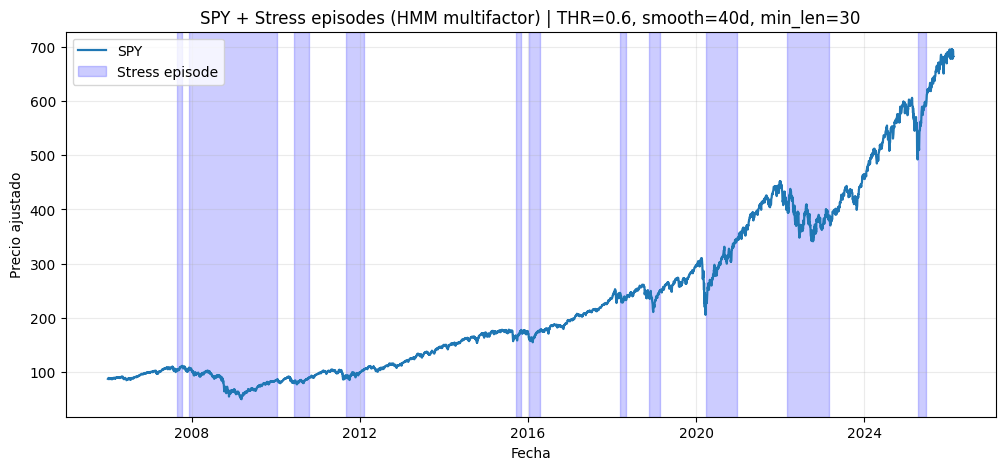

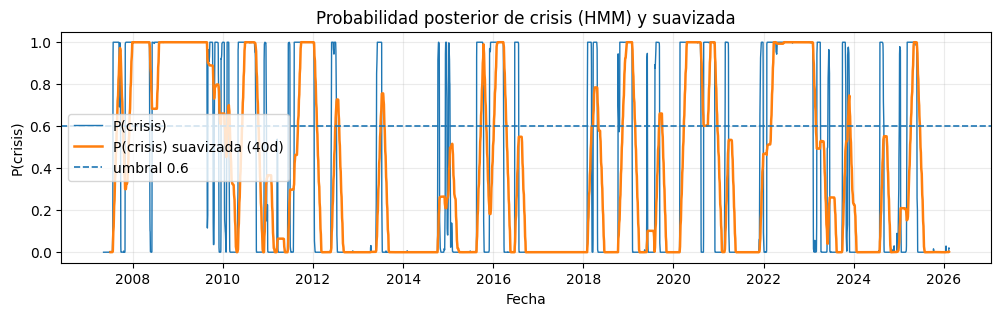

In [365]:
spy_plot = universe_px["SPY"]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(spy_plot.index, spy_plot.values, linewidth=1.6, label="SPY")

for (a, b) in episodes:
    ax.axvspan(a, b, alpha=0.20, color="blue", label="Stress episode")

# leyenda sin duplicados
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), loc="upper left")

ax.set_title(f"SPY + Stress episodes (HMM multifactor) | THR={THR}, smooth={SMOOTH}d, min_len={MIN_LEN}")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio ajustado")
ax.grid(True, alpha=0.25)
plt.show()

# Plot de probabilidad (diagnóstico)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(p_crisis.index, p_crisis, linewidth=1.0, label="P(crisis)")
ax.plot(p_crisis_smooth.index, p_crisis_smooth, linewidth=1.8, label=f"P(crisis) suavizada ({SMOOTH}d)")
ax.axhline(THR, linestyle="--", linewidth=1.2, label=f"umbral {THR}")
ax.set_title("Probabilidad posterior de crisis (HMM) y suavizada")
ax.set_xlabel("Fecha")
ax.set_ylabel("P(crisis)")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

Con los graficos anteriores es posible apreciar las clasificaciones que nuestro modelo ha realizado sobre el conjunto de datos.

En el primer gráfico, *SPY + Stress episodes (HMM multifactor)*, se observa que la clasificación de los estados de calma y crisis se adapta con precisión a la evolución del índice S&P500, identificando las caídas maximum-drawdown como estados de crisis. Este resultado es en parte al valor RV1; cuando se han realizado pruebas con valores superiores, detecta las caidas maximum-drawdown con retardo.

Con el segundo gráfico, *Probabilidad posterior de crisis (HMM) y suavizada*, es posible entender la evolución de las probabilidades de crisis obtenidas en la simulación (P(crisis)), la evolución de los valores obtenidos tras suavizarlas y a partir de qué valor se han considerado estados de crisis en la clasificación final.
Con el uso de un umbral sobre las probabilidades suavizadas hemos descartado aquellos escenarios de crisis puntuales; es decir, "*sustos*" en el mercado.

# Fase 2 — Anatomía del Riesgo 

En esta fase cuantificamos cómo cambian las distribuciones de los retornos en función de los estados del mercado, *calma* y *crisis*.

Para cada estado, calculamos:
- **Media** (retorno esperado diario)
- **Volatilidad** (desviación típica diaria)
- **Skewness** (asimetría)
- **Kurtosis (exceso)** (colas: >0 indica colas más pesadas que normal)

In [366]:
def stats(df: pd.DataFrame) -> pd.DataFrame:
    stats = pd.DataFrame({
        "N": df.count(),
        "mean_d": df.mean(),
        "vol_d": df.std(),
        "skew": df.skew(),
        "kurt_excess": df.kurt()
    })
    stats["mean_ann"] = stats["mean_d"] * 252
    stats["vol_ann"]  = stats["vol_d"] * np.sqrt(252)
    return stats

In [367]:
# Segregamos por estado
universe_calm_days = crisis_prediction[crisis_prediction == calm_state].index
universe_crisis_days = crisis_prediction[crisis_prediction == crisis_state].index

calm_returns = returns.loc[universe_calm_days]
crisis_returns = returns.loc[universe_crisis_days]

# Calculamos las estadisticas por estado
calm_stats = stats(calm_returns).add_prefix('calm_')
crisis_stats = stats(crisis_returns).add_prefix('crisis_')

universe_stats = pd.concat([calm_stats, crisis_stats], axis=1)

# Comparamos entre los diferentes estados (crisis frente a calma)
universe_stats["vol_ratio"] = universe_stats["crisis_vol_ann"] / universe_stats["calm_vol_ann"]
universe_stats["vol_increase_%"] = (universe_stats["vol_ratio"] - 1.0) * 100
universe_stats["mean_diff_ann"] = universe_stats["crisis_mean_ann"] - universe_stats["calm_mean_ann"]
universe_stats["kurt_diff"] = universe_stats["crisis_kurt_excess"] - universe_stats["calm_kurt_excess"]
universe_stats["skew_diff"] = universe_stats["crisis_skew"] - universe_stats["calm_skew"]

universe_stats["vol_increase_%"] = (universe_stats["vol_ratio"] - 1.0) * 100
universe_stats["mean_diff_ann"] = universe_stats["crisis_mean_ann"] - universe_stats["calm_mean_ann"]
universe_stats["kurt_diff"] = universe_stats["crisis_kurt_excess"] - universe_stats["calm_kurt_excess"]
universe_stats["skew_diff"] = universe_stats["crisis_skew"] - universe_stats["calm_skew"]

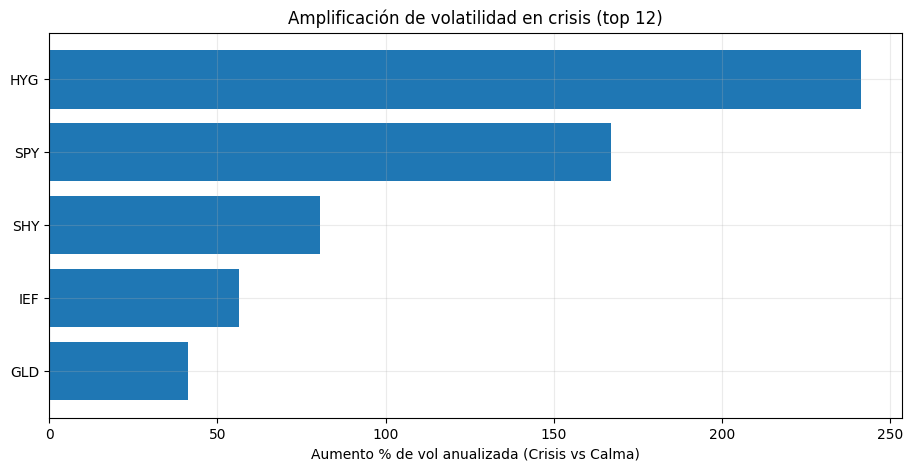

In [368]:
# (A) Top "amplificación" de volatilidad
VOL_AMPLIFICATION_TOP = 12
rank = universe_stats.sort_values("vol_increase_%", ascending=False).head(VOL_AMPLIFICATION_TOP)

fig, ax = plt.subplots(figsize=(11, 5))
ax.barh(rank.index[::-1], rank["vol_increase_%"][::-1])
ax.set_title(f"Amplificación de volatilidad en crisis (top {VOL_AMPLIFICATION_TOP})")
ax.set_xlabel("Aumento % de vol anualizada (Crisis vs Calma)")
ax.grid(True, alpha=0.25)
plt.show()

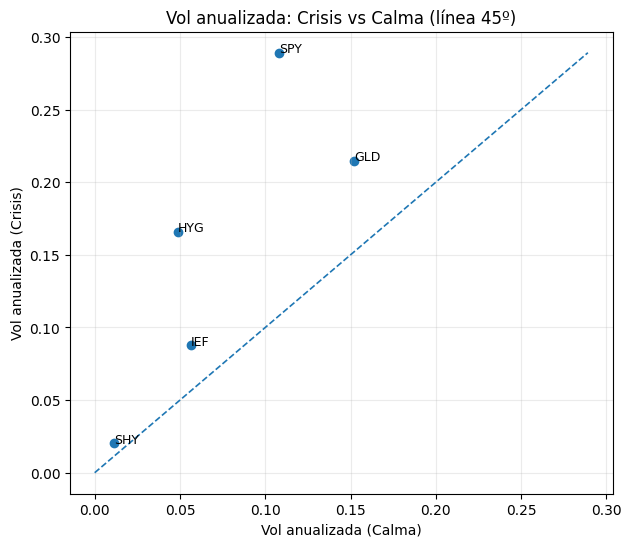

In [369]:
# (B) Scatter: vol crisis vs vol calma (línea 45º)
fig, ax = plt.subplots(figsize=(7, 6))
x = universe_stats["calm_vol_ann"].values
y = universe_stats["crisis_vol_ann"].values
ax.scatter(x, y)

mx = np.nanmax([x.max(), y.max()])
ax.plot([0, mx], [0, mx], linestyle="--", linewidth=1.2)  # línea 45º

# Etiquetar solo algunos (los más relevantes) para no saturar
labels = universe_stats.index.tolist()
for t in labels:
    ax.annotate(t, (universe_stats.loc[t, "calm_vol_ann"], universe_stats.loc[t, "crisis_vol_ann"]), fontsize=9)

ax.set_title("Vol anualizada: Crisis vs Calma (línea 45º)")
ax.set_xlabel("Vol anualizada (Calma)")
ax.set_ylabel("Vol anualizada (Crisis)")
ax.grid(True, alpha=0.25)
plt.show()

En este gráfico se aprecia qué volatilidad tiene cada activo en calma y en crisis. La línea vertical nos ayuda a visualizar dónde se situaría un activo que tiene la misma volatilidad en crisis que en calma.

Como observamos, los activos se encuentran en la parte superior del gráfico (sobre la línea), lo que nos indica que todos los activos tienen una volatilidad mayor cuando el mercado se encuentra en un escenario de crisis.

Es interesante destacar el caso del ETF SHY, que mantiene prácticamente la misma volatilidad en ambos escenarios.

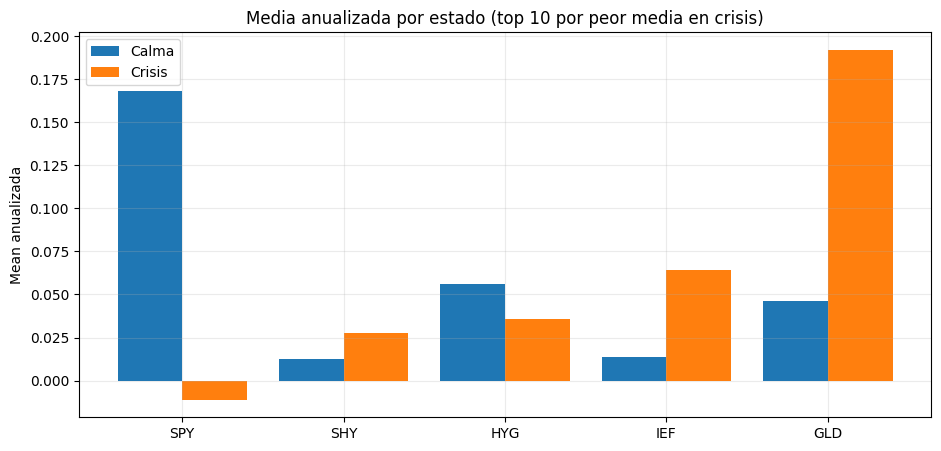

In [370]:
# (C) Mean anualizada: comparación Calma vs Crisis (top 10 por peor media en crisis)
ANN_MEAN_TOP = 10

rank_mean = universe_stats.sort_values("crisis_mean_ann").head(ANN_MEAN_TOP)  # <- aquí definimos rank_mean

fig, ax = plt.subplots(figsize=(11, 5))
idx = np.arange(len(rank_mean))
ax.bar(idx - 0.2, rank_mean["calm_mean_ann"].values, width=0.4, label="Calma")
ax.bar(idx + 0.2, rank_mean["crisis_mean_ann"].values, width=0.4, label="Crisis")
ax.set_xticks(idx)
ax.set_xticklabels(rank_mean.index, rotation=0)
ax.set_title(f"Media anualizada por estado (top {ANN_MEAN_TOP} por peor media en crisis)")
ax.set_ylabel("Mean anualizada")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

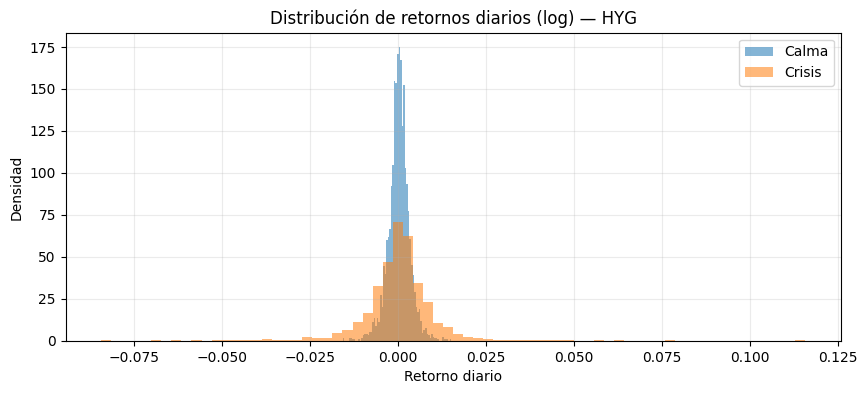

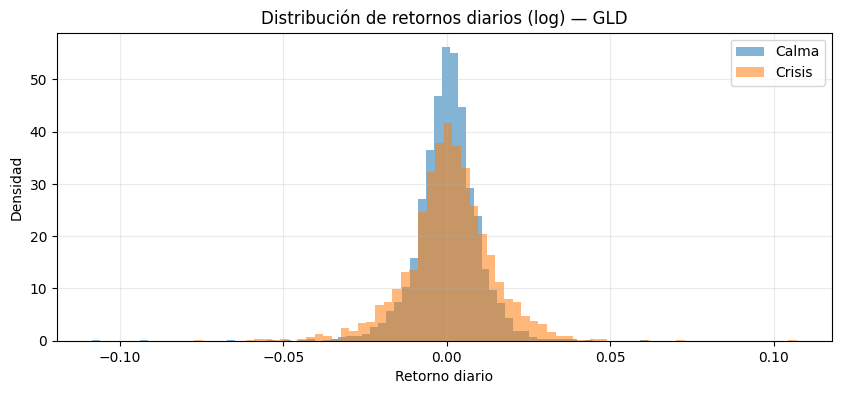

In [371]:
# (D) Distribuciones (hist) para HYG y GLD por estado
def plot_hist_asset(ticker, bins=70):
    if ticker not in returns.columns:
        print(f"[WARN] {ticker} no está en retornos.")
        return
    r0 = calm_returns[ticker].dropna()
    r1 = crisis_returns[ticker].dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(r0.values, bins=bins, density=True, alpha=0.55, label="Calma")
    ax.hist(r1.values, bins=bins, density=True, alpha=0.55, label="Crisis")
    ax.set_title(f"Distribución de retornos diarios (log) — {ticker}")
    ax.set_xlabel("Retorno diario")
    ax.set_ylabel("Densidad")
    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.show()

plot_hist_asset("HYG")
plot_hist_asset("GLD")

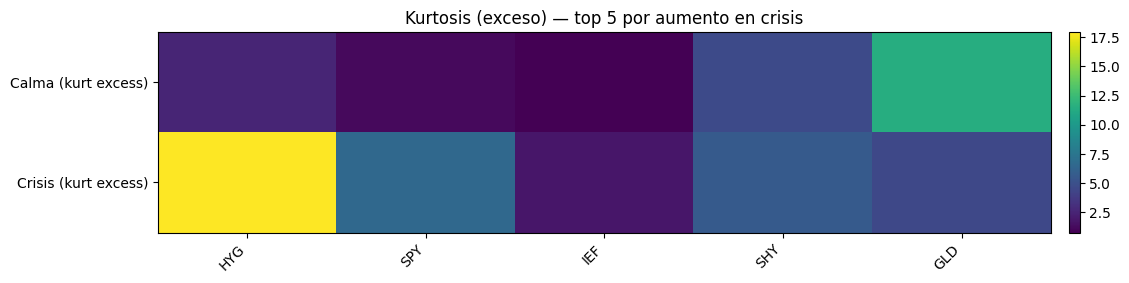

In [372]:
# (E) “Mapa rápido” de colas/asimetría (top por kurtosis diff)
topK = min(15, len(universe_stats))
rank_k = universe_stats.sort_values("kurt_diff", ascending=False).head(topK)
vals = np.vstack([rank_k["calm_kurt_excess"].values, rank_k["crisis_kurt_excess"].values])

fig, ax = plt.subplots(figsize=(12, 2.6))
im = ax.imshow(vals, aspect="auto")
ax.set_yticks([0,1])
ax.set_yticklabels(["Calma (kurt excess)", "Crisis (kurt excess)"])
ax.set_xticks(np.arange(topK))
ax.set_xticklabels(rank_k.index, rotation=45, ha="right")
ax.set_title(f"Kurtosis (exceso) — top {topK} por aumento en crisis")
plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
plt.show()

In [373]:
if "HYG" in universe_stats.index:
    hyg = universe_stats.loc["HYG"]
    print(f"(HYG) Vol anualizada Calma:  {hyg['calm_vol_ann']:.4f}")
    print(f"(HYG) Vol anualizada Crisis: {hyg['crisis_vol_ann']:.4f}")
    print(f"(HYG) Aumento (%):           {hyg['vol_increase_%']:.2f}%  | Ratio: {hyg['vol_ratio']:.3f}")
else:
    print("(HYG) No disponible en el dataset.")

if "GLD" in universe_stats.index:
    gld = universe_stats.loc["GLD"]
    print(f"(GLD) Mean anualizada Calma:  {gld['calm_mean_ann']:.4f}")
    print(f"(GLD) Mean anualizada Crisis: {gld['crisis_mean_ann']:.4f}  | Δ: {gld['mean_diff_ann']:.4f}")
    print(f"(GLD) Vol anualizada Calma:   {gld['calm_vol_ann']:.4f}")
    print(f"(GLD) Vol anualizada Crisis:  {gld['crisis_vol_ann']:.4f}  | Ratio: {gld['vol_ratio']:.3f}")

    # Extra: correlación GLD vs SPY condicional
    if "SPY" in returns.columns:
        corr_calm = calm_returns["GLD"].corr(calm_returns["SPY"])
        corr_cris = crisis_returns["GLD"].corr(crisis_returns["SPY"])
        print(f"(GLD vs SPY) Corr Calma: {corr_calm:.3f} | Corr Crisis: {corr_cris:.3f}")
else:
    print("(GLD) No disponible en el dataset.")


(HYG) Vol anualizada Calma:  0.0486
(HYG) Vol anualizada Crisis: 0.1659
(HYG) Aumento (%):           241.31%  | Ratio: 3.413
(GLD) Mean anualizada Calma:  0.0462
(GLD) Mean anualizada Crisis: 0.1921  | Δ: 0.1459
(GLD) Vol anualizada Calma:   0.1519
(GLD) Vol anualizada Crisis:  0.2147  | Ratio: 1.413
(GLD vs SPY) Corr Calma: 0.077 | Corr Crisis: 0.041


1) ¿Cuánto aumenta la volatilidad de **HYG** al pasar de Estado 0 a Estado 1?

La volatilidad del HYG crece 4 puntos porcentuales, algo esperable ya que, al ser bonos de alto riesgo se ven muy influenciados por el estado del mercado.

2) ¿Sigue siendo **GLD** un activo refugio?

La correlación del oro respecto al *S&P500* es del 7,7% en calma y del ~4% en crisis. Que su correlación disminuya en crisis nos indica que no depende tanto del índice como otros activos, por lo que, podemos considerar que sí es un activo refugio por descorrelación.


## Fase 3 — Cuando la diversificación falla (cópulas)

### 1) Correlación Pearson por régimen
- Se calcula la matriz de correlación de retornos diarios **condicional a cada estado** (HMM).


### 2) t-cópula multivariante (dependencia en colas)
- Se ajusta una **t-cópula** en cada régimen usando pseudo-observaciones (ranks → U(0,1)).
- La t-cópula introduce dependencia en colas mediante los **grados de libertad**:
  - **Alto** ⇒ comportamiento cercano a Gaussiana (colas “finas”) → típico de *Calma*.
  - **Bajo** ⇒ colas gruesas y más probabilidad de extremos conjuntos → típico de *Crisis*.

#### Datos

Se explora el movimiento diario, desde 2006-01-01 hasta hoy, de los siguientes activos:
- Equities: AAPL, AMZN, BAC, BRK-B, CVX, ENPH, GME, GOOGL, JNJ, JPM, MSFT, NVDA, PG, XOM
- High Yield: HYG
- Gold: GLD
- Bonos gobierno USA 10Y y 2Y (proxies líquidos): IEF (7–10Y Treasury) y SHY (1–3Y Treasury)

#### Fuentes:
- Precios ajustados (acciones/ETFs): Yahoo Finance (via `yfinance`)

In [374]:
# Subconjuntos para interpretacion
equities = ["AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GME","GOOGL","JNJ","JPM","MSFT","NVDA","PG","XOM"]
def_assets  = ["IEF","SHY","GLD"]
risk_assets = ["HYG"] + equities

wallet = risk_assets + def_assets

print("Activos totales:", len(wallet), "| Risk assets:", len(risk_assets), "| Defensivos:", len(def_assets))

Activos totales: 18 | Risk assets: 15 | Defensivos: 3


In [375]:
#Descarga de todos los tickers
wallet_px = yf.download(
    wallet,
    start=FROM,
    end=TO,
    auto_adjust=True,
    progress=False)["Close"]

In [376]:
# Retornos log (sin dropna global)
wallet_returns = np.log(wallet_px).diff()

print("Dias con datos en HMM:", len(crisis_prediction))
print("Dias con datos en la cartera:", len(wallet_returns))

# Cogemos los dias comunes entre HMM y los precios de la cartera
common_idx = wallet_returns.index.intersection(crisis_prediction.index)
wallet_crisis_prediction = crisis_prediction.loc[common_idx]
wallet_returns = wallet_returns.loc[common_idx]

print("Dias en comun:", len(wallet_returns), "| Dias de crisis:", 100 * wallet_crisis_prediction.mean(), "%")

Dias con datos en HMM: 4723
Dias con datos en la cartera: 5061
Dias en comun: 4723 | Dias de crisis: 38.492483590937965 %


In [377]:
def vec_offdiag(df: pd.DataFrame):
    values = df.values
    mask = ~np.eye(values.shape[0], dtype=bool)
    return values[mask]

def offdiag_mean(df: pd.DataFrame) -> float:
    return np.nanmean(vec_offdiag(df))

In [378]:
# -----------------------------
# 1) Correlación Pearson por régimen
# -----------------------------

# Minimo numero de dias que tenemos que tener un ticker en la cartera para considerarlo
TICKER_MIN_SAMPLES = 400

wallet_calm_returns = wallet_returns.loc[wallet_crisis_prediction == calm_state]
wallet_crisis_returns = wallet_returns.loc[wallet_crisis_prediction == crisis_state]

# Nos quedamos los tickers que tengan suficientes datos en ambos regimenes
tickers_to_keep = []
for c in wallet_returns.columns:
    n0 = wallet_calm_returns[c].count()
    n1 = wallet_crisis_returns[c].count()
    if (n0 >= TICKER_MIN_SAMPLES) and (n1 >= TICKER_MIN_SAMPLES):
        tickers_to_keep.append(c)

wallet_calm_returns = wallet_calm_returns[tickers_to_keep]
wallet_crisis_returns = wallet_crisis_returns[tickers_to_keep]

wallet_calm_correlation = wallet_calm_returns.corr(method="pearson")
wallet_crisis_correlation = wallet_crisis_returns.corr(method="pearson")

print(f"Activos con N >= {TICKER_MIN_SAMPLES} en ambos regimenes: {len(tickers_to_keep)}")
print("Corr media off-diag (Calma):  ", offdiag_mean(wallet_calm_correlation))
print("Corr media off-diag (Crisis): ", offdiag_mean(wallet_crisis_correlation))


Activos con N >= 400 en ambos regimenes: 18
Corr media off-diag (Calma):   0.1394820339877462
Corr media off-diag (Crisis):  0.28531002871590927


In [379]:
risk_tickers = [t for t in risk_assets if t in tickers_to_keep]
risk_tickers_calm_returns = wallet_calm_returns[risk_tickers].corr()
risk_tickers_crisis_returns = wallet_calm_returns[risk_tickers].corr()
print(f"Risk Assets con N >= {TICKER_MIN_SAMPLES} en ambos regimenes: {len(risk_tickers)}")
print("Corr media off-diag (Calma):  ", offdiag_mean(risk_tickers_calm_returns))
print("Corr media off-diag (Crisis): ", offdiag_mean(risk_tickers_crisis_returns))

Risk Assets con N >= 400 en ambos regimenes: 15
Corr media off-diag (Calma):   0.20996004617352382
Corr media off-diag (Crisis):  0.20996004617352382


In [380]:
def plot_heatmap_corr(C: pd.DataFrame, title: str, vmin=-1, vmax=1):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(C.values, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_xticks(range(C.shape[1]))
    ax.set_yticks(range(C.shape[0]))
    ax.set_xticklabels(C.columns, rotation=90)
    ax.set_yticklabels(C.index)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    ax.grid(False)
    plt.show()

### Gráficos

In [381]:
# Configuracion
V_MIN = -1
V_MAX = 1
# Agrupamos los datos que no difieran en más de 0.03 unidades de retorno log
GROUP_RANGE = 0.03

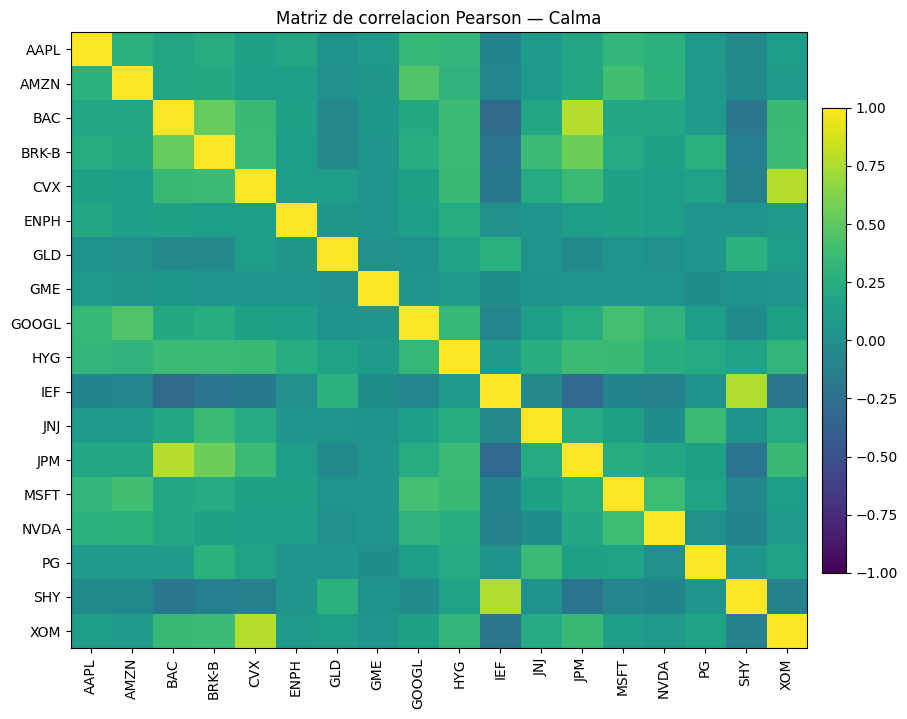

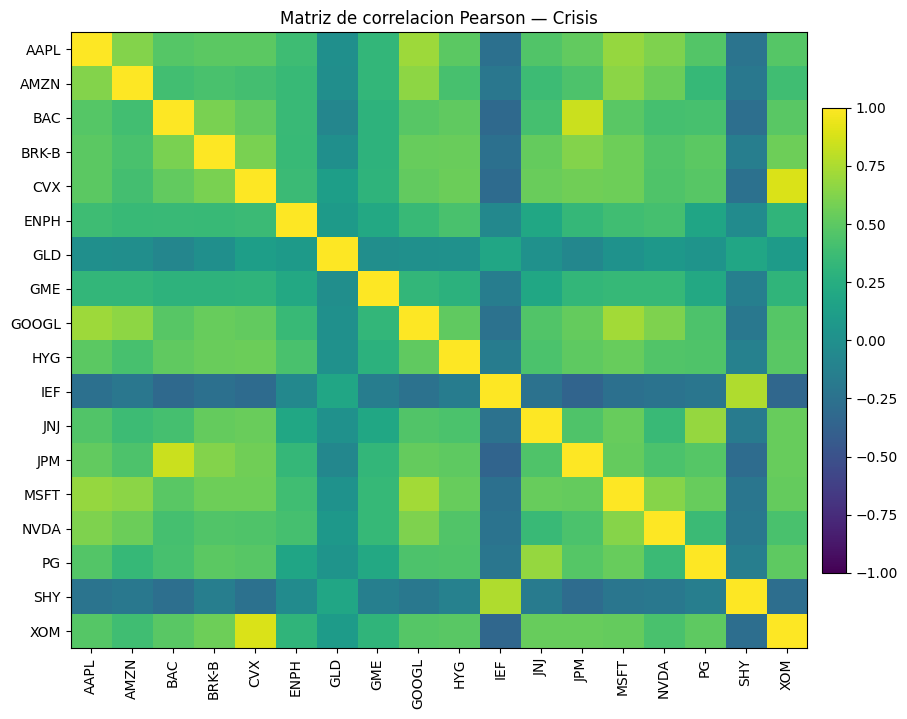

In [382]:
plot_heatmap_corr(wallet_calm_correlation, "Matriz de correlacion Pearson — Calma", vmin=V_MIN, vmax=V_MAX)
plot_heatmap_corr(wallet_crisis_correlation, "Matriz de correlacion Pearson — Crisis", vmin=V_MIN, vmax=V_MAX)

Mediante estos gráficos se aprecia que la correlación es mayor en crisis, aunque observamos SHY (bonos a 2 años), IEF (bonos a 10 años) y GLD disminuyen la correlación con el resto de activos cuando sucede un escenario de crisis, lo que proporciona una buena opción para diversificar la cartera cuando el mercado está en crisis.

Es importante recordar que estos datos están normalizados y por tanto **no son buenos representantes del mundo real**. Para ajustarnos con mayor fidelidad a la realidad, más adelante, calcularemos y optimizaremos las cópulas de los activos en ambos escenarios.

#### Visualización de las correlaciones en grupos de *GROUP_RANGE* decimales

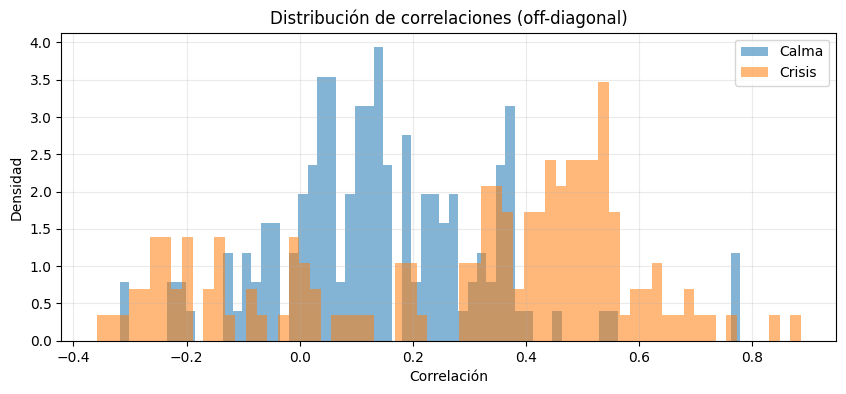

In [383]:
wallet_calm_correlation_values = vec_offdiag(wallet_calm_correlation)
wallet_crisis_correlation_values = vec_offdiag(wallet_crisis_correlation)

bins = int((V_MAX - V_MIN) / GROUP_RANGE)
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(wallet_calm_correlation_values, bins=bins, density=True, alpha=0.55, label="Calma")
ax.hist(wallet_crisis_correlation_values, bins=bins, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de correlaciones (off-diagonal)")
ax.set_xlabel("Correlación")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

### Cópulas

Se utiliza la distribución t-student tanto en calma y en crisis para considerar especialmente los datos en las colas de la distribución, optimizando los grados de libertad en cada estado.

Se ha querido utilizar la misma distribución en ambos escenarios para poder realizar comparaciones más "alineadas".

In [384]:
def pseudo_obs(df: pd.DataFrame) -> np.ndarray:
    """Pseudo-observaciones U(0,1) via ranks: u = rank/(n+1)."""
    X = df.values
    n, k = X.shape
    U = np.empty_like(X, dtype=float)
    for j in range(k):
        col = X[:, j]
        # rankdata maneja empates
        r = st.rankdata(col, method="average")
        U[:, j] = r / (n + 1.0)
    return U

def nearest_psd(A: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Proyecta a PSD por clipping de eigenvalores."""
    A = 0.5 * (A + A.T)
    w, V = np.linalg.eigh(A)
    w = np.maximum(w, eps)
    B = (V * w) @ V.T
    # normalizar a correlación (diag = 1)
    d = np.sqrt(np.diag(B))
    B = B / np.outer(d, d)
    return 0.5 * (B + B.T)

def t_tail_dependence(rho: float, nu: float) -> float:
    """
    Coeficiente de dependencia en cola (simétrica) para t-copula:
    λ = 2 * t_{nu+1}(-sqrt((nu+1)*(1-rho)/(1+rho)))
    """
    if rho >= 0.999999:
        return 1.0
    if rho <= -0.999999:
        return 0.0
    a = -np.sqrt((nu + 1.0) * (1.0 - rho) / (1.0 + rho))
    return 2.0 * st.t.cdf(a, df=nu + 1.0)


def fit_t_copula_ifm(df: pd.DataFrame, nu_grid, shrink=0.02):

    X = df.dropna(axis=0, how="any")

    U = pseudo_obs(X)
    k = U.shape[1]
    ll_list = []

    for nu in nu_grid:
        # Transformación t
        Z = st.t.ppf(U, df=nu)
        # Correlación en el espacio latente
        Rho = np.corrcoef(Z, rowvar=False)
        # Shrinkage leve para estabilidad
        Rho = (1 - shrink) * Rho + shrink * np.eye(k)
        Rho = nearest_psd(Rho)

        # log c(u) = log f_tk(Z;nu,Rho) - sum log f_t1(Z_i;nu)
        mvt = st.multivariate_t(loc=np.zeros(k), shape=Rho, df=nu)
        ll_m = mvt.logpdf(Z).sum()
        ll_u = st.t.logpdf(Z, df=nu).sum()
        ll = ll_m - ll_u
        ll_list.append((nu, ll, len(X), k))

    ll_df = pd.DataFrame(ll_list, columns=["nu", "loglik", "N", "K"]).sort_values("loglik", ascending=False)
    nu_hat = int(ll_df.iloc[0]["nu"])

    # Re-estimar Rho con nu_hat
    Z = st.t.ppf(U, df=nu_hat)
    Rho = np.corrcoef(Z, rowvar=False)
    Rho = (1 - shrink) * Rho + shrink * np.eye(k)
    Rho = nearest_psd(Rho)

    return nu_hat, Rho, ll_df, X.columns

In [385]:
print("--- Ajuste t-copula (multivariante) ---")
print("Activos usados para copula:", tickers_to_keep)

wallet_calm_returns = wallet_calm_returns.dropna(how="any")
wallet_crisis_returns = wallet_crisis_returns.dropna(how="any")

nu_grid = [6,7,8,9,10,12,15,20,30,50,80, 100]
calm_nu, nu_calm_corr, calm_ll, calm_columns = fit_t_copula_ifm(wallet_calm_returns, nu_grid=nu_grid, shrink=0.02)
crisis_nu, nu_crisis_corr, crisis_ll, crisis_columns = fit_t_copula_ifm(wallet_crisis_returns, nu_grid=nu_grid, shrink=0.02)

# Un valor alto indica colas mas grandes (mas separados). Un valor pequenho indica que los activos estan mas correlacionados
print(f"t-copula Calma:  nu_hat = {calm_nu}")
print(f"t-copula Crisis: nu_hat = {crisis_nu}")

--- Ajuste t-copula (multivariante) ---
Activos usados para copula: ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GLD', 'GME', 'GOOGL', 'HYG', 'IEF', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'SHY', 'XOM']
t-copula Calma:  nu_hat = 15
t-copula Crisis: nu_hat = 10


In [386]:
# Plot ll vs nu
def plot_ll(ll_df, title):
    tmp = ll_df.sort_values("nu")
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(tmp["nu"], tmp["loglik"], marker="o")
    ax.set_title(title)
    ax.set_xlabel("nu (df)")
    ax.set_ylabel("log-likelihood (copula)")
    ax.grid(True, alpha=0.25)
    plt.show()

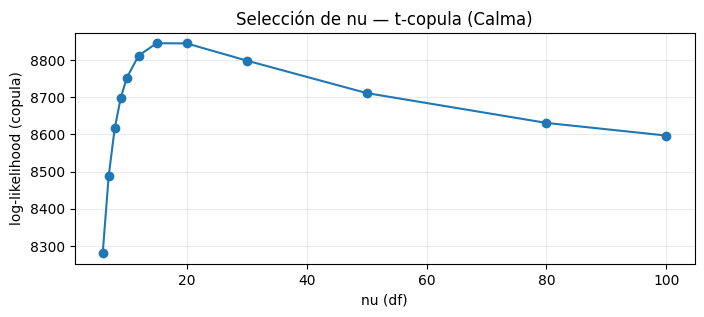

t-copula — Calma (mejores nu por log-likelihood)


,nu,loglik,N,K
6,15,8845.213496,2480,18
7,20,8844.742520,2480,18
5,12,8812.189839,2480,18
8,30,8798.588748,2480,18
4,10,8751.734719,2480,18
9,50,8711.326996,2480,18
3,9,8697.838407,2480,18
10,80,8630.988457,2480,18
2,8,8616.172868,2480,18
11,100,8597.021679,2480,18


In [387]:
plot_ll(calm_ll, "Selección de nu — t-copula (Calma)")
print("t-copula — Calma (mejores nu por log-likelihood)")
calm_ll.head(10)

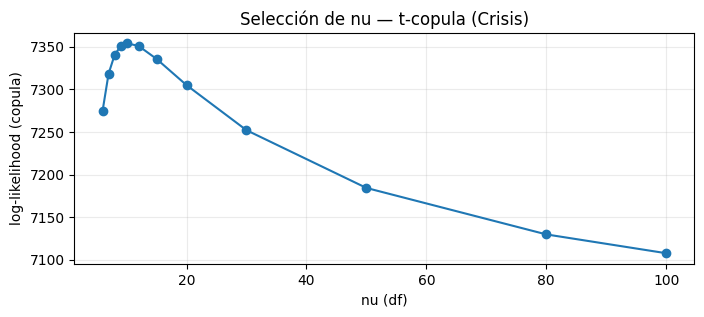

t-copula — Crisis (mejores nu por log-likelihood)


,nu,loglik,N,K
4,10,7354.177577,1008,18
5,12,7350.992007,1008,18
3,9,7350.588942,1008,18
2,8,7340.326347,1008,18
6,15,7335.746252,1008,18
1,7,7318.394477,1008,18
7,20,7305.009119,1008,18
0,6,7274.833318,1008,18
8,30,7252.123325,1008,18
9,50,7184.382654,1008,18


In [388]:
plot_ll(crisis_ll, "Selección de nu — t-copula (Crisis)")
print("t-copula — Crisis (mejores nu por log-likelihood)")
crisis_ll.head(10)

Tras la evaluación y optimización de las cópulas en ambos estados se obtiene un grado de libertad igual a 15, en calma, y 10 en crisis.

Esto coincide con el mundo real, ya que durante una crisis, los activos están más relacionados entre sí, ya que, normalmente, sufren caídas todos a la vez.

#### Recalculamos las correlaciones con las cópulas optimizadas

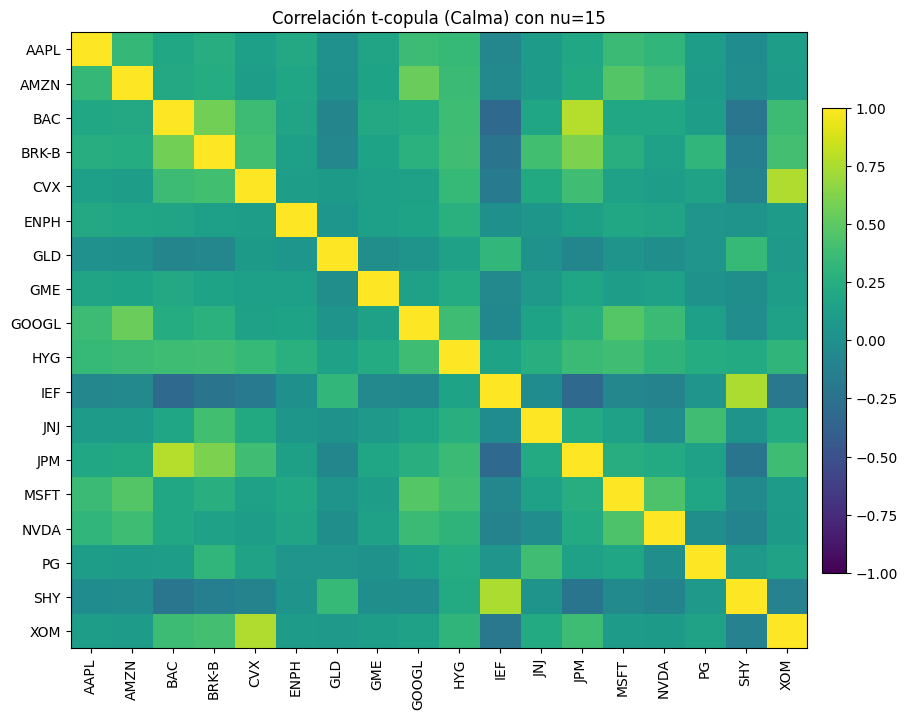

In [389]:
nu_calm_corr_df = pd.DataFrame(nu_calm_corr, index=calm_columns, columns=calm_columns)
plot_heatmap_corr(nu_calm_corr_df, f"Correlación t-copula (Calma) con nu={calm_nu}", vmin=-1, vmax=1)

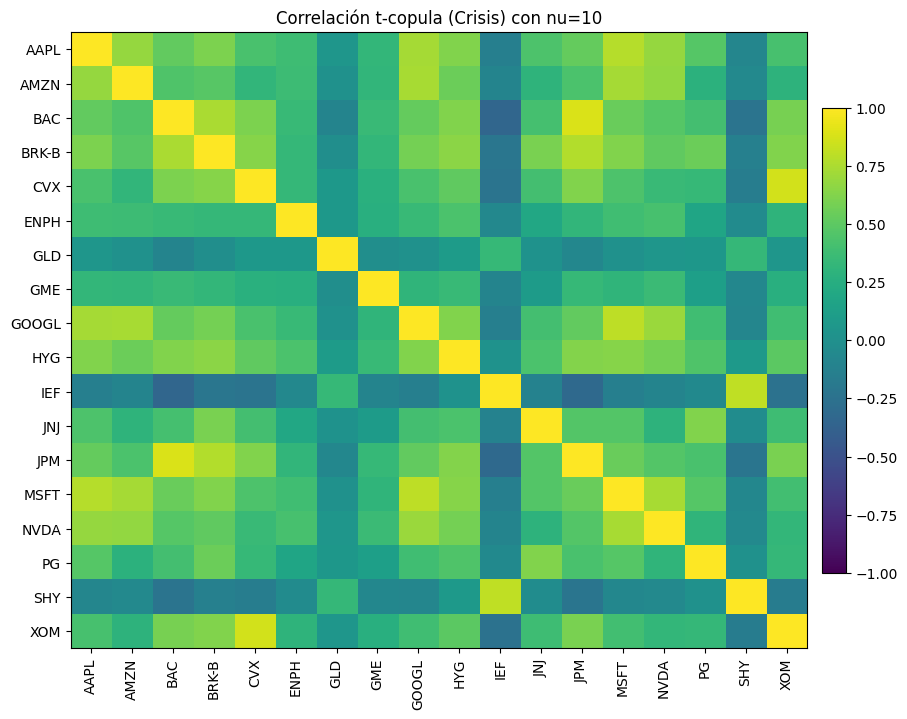

In [390]:
nu_crisis_corr_df = pd.DataFrame(nu_crisis_corr, index=crisis_columns, columns=crisis_columns)
plot_heatmap_corr(nu_crisis_corr_df, f"Correlación t-copula (Crisis) con nu={crisis_nu}", vmin=-1, vmax=1)

Las correlaciones obtenidas se asemejan mucho a las calculadas con Pearson. No obstante, de forma generalizada, en crisis se aprecia una mayor correlación entre los activos.

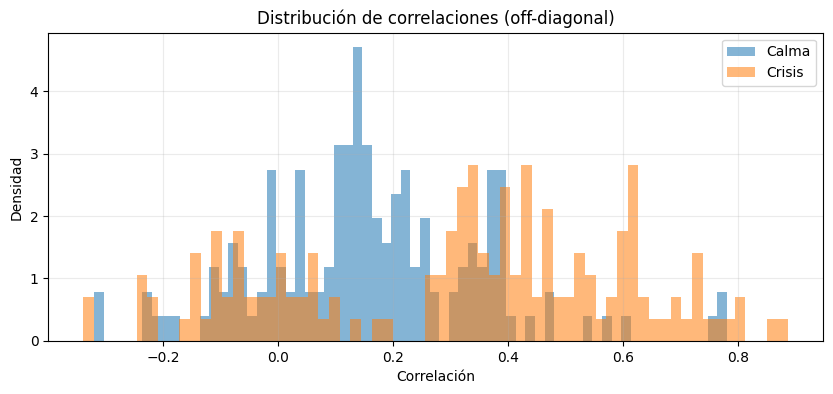

In [391]:
copula_calm_correlation_values = vec_offdiag(nu_calm_corr_df)
copula_crisis_correlation_values = vec_offdiag(nu_crisis_corr_df)

bins = int((V_MAX - V_MIN) / GROUP_RANGE)
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(copula_calm_correlation_values, bins=bins, density=True, alpha=0.55, label="Calma")
ax.hist(copula_crisis_correlation_values, bins=bins, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de correlaciones (off-diagonal)")
ax.set_xlabel("Correlación")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

#### Correlación entre pares de activos de acuerdo a las cópulas

In [392]:
def pair_table_taildep(Rho, cols, nu, top=12):
    cols = list(cols)
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            rho = float(Rho[i, j])
            lam = t_tail_dependence(rho, nu)
            out.append((cols[i], cols[j], rho, lam))
    df = pd.DataFrame(out, columns=["asset_i","asset_j","rho_latent","lambda_tail"])
    df = df.sort_values("lambda_tail", ascending=False)
    return df.head(top), df


top1, all1 = pair_table_taildep(nu_crisis_corr, crisis_columns, crisis_nu, top=12)

In [393]:
top0, all0 = pair_table_taildep(nu_calm_corr, calm_columns, calm_nu, top=12)
print("t-copula — Top tail dependence (Calma)")
top0.head(12)

t-copula — Top tail dependence (Calma)


,asset_i,asset_j,rho_latent,lambda_tail
42,BAC,JPM,0.780673,0.179482
74,CVX,XOM,0.765311,0.164064
130,IEF,SHY,0.756459,0.155815
56,BRK-B,JPM,0.608288,0.065897
33,BAC,BRK-B,0.572941,0.053526
23,AMZN,GOOGL,0.540296,0.044090
112,GOOGL,MSFT,0.473354,0.029414
28,AMZN,MSFT,0.467150,0.028315
143,MSFT,NVDA,0.441557,0.024173
61,BRK-B,XOM,0.399985,0.018621


In [394]:
top1, all1 = pair_table_taildep(nu_crisis_corr, crisis_columns, crisis_nu, top=12)
print("t-copula — Top tail dependence (Crisis)")
top1.head(12)

t-copula — Top tail dependence (Crisis)


,asset_i,asset_j,rho_latent,lambda_tail
42,BAC,JPM,0.887238,0.434724
74,CVX,XOM,0.861211,0.384513
130,IEF,SHY,0.808532,0.303615
112,GOOGL,MSFT,0.804454,0.298253
12,AAPL,MSFT,0.779112,0.267252
56,BRK-B,JPM,0.771898,0.259102
33,BAC,BRK-B,0.747833,0.233825
23,AMZN,GOOGL,0.735245,0.221674
143,MSFT,NVDA,0.734724,0.221186
28,AMZN,MSFT,0.733946,0.220459


Al analizar los primeros 12 pares con mayor dependencia, observamos que el sector tecnológico y el bancario son los que tienen una correlación elevada, por lo que, durante una diversificación, invertir en estos activos no aportaría demasiado.

In [395]:
print("Resumen tail dependence (t-copula):")
print("Media λ (Calma): ", all0["lambda_tail"].mean())
print("Media λ (Crisis):", all1["lambda_tail"].mean())

Resumen tail dependence (t-copula):
Media λ (Calma):  0.009621873260781575
Media λ (Crisis): 0.06797239349172014


#### ¿Qué características del mercado dirías que realmente distinguen un estado del otro?

Destacamos que la dependencia entre los activos cuando se produce un escenario de crisis es mucho mayor que cuando está en calma.

## Fase 4: El Motor de Simulación

### 1) Sanity Check
Con la cartera equiponderada, se realiza una simulación de Monte Carlo de N_PATHS para testear nuestro modelo HMM ante la aleatoriedad.

### 2) Reproducción de regímenes
Comparamos los resultados simulados con la realidad.

### 3) Reproducción de riesgo y dependencia

Utilizamos las medidas VaR y Expected Shortfall para evaluar los peores días simulados de cada estado contra la realidad.


Configuracion

In [396]:
# Horizonte ~ 6 meses (trading days)
N_PATHS = 10_000
MONTH_WINDOW = 6
N_DAYS_WINDOW = 20 * MONTH_WINDOW

label = lambda state: f"Estado {state} (Crisis)" if state == crisis_state else f"Estado {st} (Calma)"


In [397]:
# WARN: No podemos usar la diferencia simple de los precios cerrados por la escala
percentage_wallet_returns = np.expm1(wallet_returns)  # r = exp(logr)-1

# retorno diario (aritmético) de la cartera
daily_percentage_return = percentage_wallet_returns.mean(axis=1).dropna()

wallet_wealth = (1.0 + daily_percentage_return).cumprod()
print(f"[REAL] Periodo: {daily_percentage_return.index.min().date()} -> {daily_percentage_return.index.max().date()}")
print(f"[REAL] Nº días (retornos): {len(daily_percentage_return)}")
print(f"[REAL] Wealth final (base 1): {wallet_wealth.iloc[-1]:.3f}") # El final representa el resultado "final" tras lo acumulado anteriormente

[REAL] Periodo: 2007-05-09 -> 2026-02-13
[REAL] Nº días (retornos): 4723
[REAL] Wealth final (base 1): 23.832


In [398]:
# Ventana de comparación (últimos ~6 meses)
# Si tenemos menos datos de los que se piden
window_size = min(N_DAYS_WINDOW, len(daily_percentage_return))
windowed_daily_percentage_returns = daily_percentage_return.iloc[-window_size:]

wealth = np.empty(window_size + 1)
wealth[0] = 1.0
wealth[1:] = np.cumprod(1.0 + windowed_daily_percentage_returns.values)

# Estado inicial para la simulación: estado al inicio de la ventana real (más “justo” para comparar)
windowed_crisis_prediction = wallet_crisis_prediction.reindex(windowed_daily_percentage_returns.index, method="ffill")
start_state = int(windowed_crisis_prediction.iloc[0])

In [399]:
# Ordenamos para poder trabajar en la simulacion con los percentiles
calm_lookup = np.sort(wallet_calm_returns.values, axis=0)
crisis_lookup = np.sort(wallet_crisis_returns.values, axis=0)

#### MonteCarlo

In [400]:
random_generator = np.random.default_rng(SEED)
transition_matrix = np.asarray(hmm.transmat_) # Probabilidad de seguir en crisis, en calma o cambiar entre estados

simulated_returns_percentages = np.empty((N_PATHS, window_size), dtype=np.float64)
simulated_wealth = np.empty((N_PATHS, window_size + 1), dtype=np.float64)
# El wealth inicial es 1
simulated_wealth[:, 0] = 1.0

# Todos los resultados de la simulacion
all_simulation_states = np.empty((N_PATHS, window_size), dtype=np.int8)
# Simulacion "actual" en el bucle
t_simulation_states = np.full(N_PATHS, start_state, dtype=np.int8)

In [401]:
def inv_ecdf_from_sorted(U: np.ndarray, sorted_vals: np.ndarray) -> np.ndarray:
    """
    Inversa empírica rápida usando array ordenado por columna.
    U: (m,k) en (0,1)
    sorted_vals: (n,k) retornos log ordenados por columna
    """
    n = sorted_vals.shape[0]
    # índices fraccionales
    x = U * (n - 1)
    i0 = np.floor(x).astype(int)
    i1 = np.minimum(i0 + 1, n - 1)
    w = x - i0

    v0 = np.take_along_axis(sorted_vals, i0, axis=0)
    v1 = np.take_along_axis(sorted_vals, i1, axis=0)
    return v0 + (v1 - v0) * w

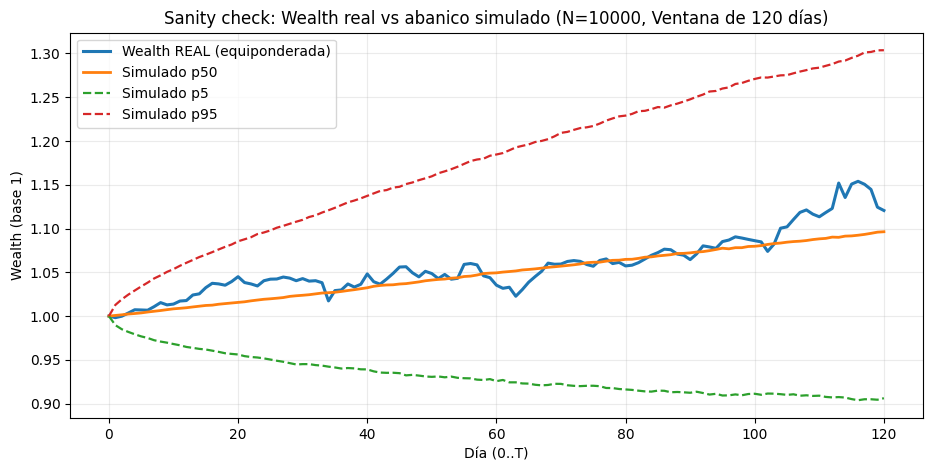

In [402]:

eps = 1e-12
n_tickers = len(tickers_to_keep)

for t in range(window_size):
    all_simulation_states[:, t] = t_simulation_states

    # Simular retornos segun si son crisis o calma
    for state in np.unique(t_simulation_states):
        idx = np.where(t_simulation_states == state)[0]
        n_states = len(idx)

        if n_states == 0:
            continue

        if int(state) == crisis_state:
            nu = int(crisis_nu)
            Rho = np.asarray(nu_crisis_corr)
            lookup = crisis_lookup
        else:
            nu = int(calm_nu)
            Rho = np.asarray(nu_calm_corr)
            lookup = calm_lookup

        # 1) t-cópula: muestrear Z ~ t_k(0, Rho, nu) y pasar a U con CDF univariante t
        Z = st.multivariate_t(loc=np.zeros(n_tickers), shape=Rho, df=nu).rvs(size=n_states, random_state=random_generator)
        Z = np.atleast_2d(Z)
        U = st.t.cdf(Z, df=nu)
        U = np.clip(U, eps, 1 - eps)

        # 2) Marginales empíricas (log-returns)
        logR_sim = inv_ecdf_from_sorted(U, lookup)

        # 3) Cartera equiponderada (aritmética) y guardar
        simulated_returns_percentages[idx, t] = np.expm1(logR_sim).mean(axis=1)

    # Transición Markov -> siguiente estado
    u = random_generator.random(N_PATHS)
    cumP = np.cumsum(transition_matrix[t_simulation_states], axis=1)  # (N, n_states)
    t_simulation_states = (u[:, None] > cumP).sum(axis=1).astype(np.int8)

    simulated_wealth[:, t + 1] = simulated_wealth[:, t] * (1.0 + simulated_returns_percentages[:, t])

p5  = np.percentile(simulated_wealth, 5, axis=0)
p50 = np.percentile(simulated_wealth, 50, axis=0)
p95 = np.percentile(simulated_wealth, 95, axis=0)

x = np.arange(window_size + 1)
plt.figure(figsize=(11, 5))
plt.plot(x, wealth, linewidth=2.2, label="Wealth REAL (equiponderada)")
plt.plot(x, p50, linewidth=2.0, label="Simulado p50")
plt.plot(x, p5,  linestyle="--", linewidth=1.6, label="Simulado p5")
plt.plot(x, p95, linestyle="--", linewidth=1.6, label="Simulado p95")
plt.title(f"Sanity check: Wealth real vs abanico simulado (N={N_PATHS}, Ventana de {window_size} días)")
plt.xlabel("Día (0..T)")
plt.ylabel("Wealth (base 1)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


In [403]:
simulated_daily_returns = simulated_returns_percentages.ravel()
daily_returns = windowed_daily_percentage_returns.values

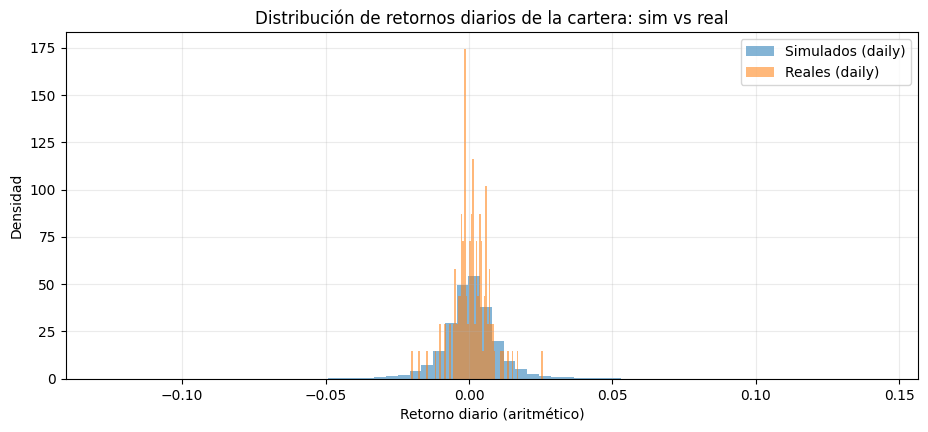

In [404]:
plt.figure(figsize=(11, 4.5))
plt.hist(simulated_daily_returns, bins=bins, density=True, alpha=0.55, label="Simulados (daily)")
plt.hist(daily_returns, bins=80, density=True, alpha=0.55, label="Reales (daily)")
plt.title("Distribución de retornos diarios de la cartera: sim vs real")
plt.xlabel("Retorno diario (aritmético)")
plt.ylabel("Densidad")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

In [405]:
# Percentiles
qs = [1, 5, 50, 95, 99]
print("\nPercentiles retornos diarios cartera (aritméticos)")
print("q    real       simulado")
for q in qs:
    print(f"{q:>2}%  {np.percentile(daily_returns, q): .5f}  {np.percentile(simulated_daily_returns, q): .5f}")


Percentiles retornos diarios cartera (aritméticos)
q    real       simulado
 1%  -0.01706  -0.02764
 5%  -0.00856  -0.01468
50%   0.00092   0.00067
95%   0.00905   0.01641
99%   0.01639   0.03134


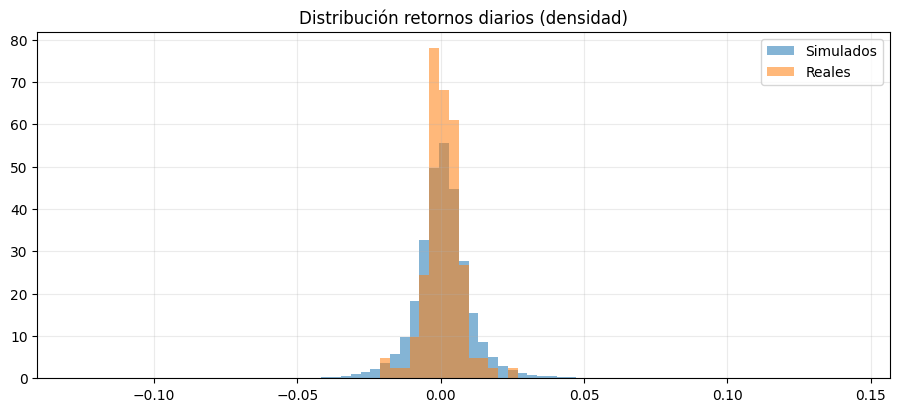

In [406]:
# Distribucion de retornos entre real y simulado
all_data = np.r_[simulated_daily_returns, daily_returns]
bins = np.linspace(all_data.min(), all_data.max(), 80)

plt.figure(figsize=(11,4.5))
plt.hist(simulated_daily_returns, bins=bins, density=True, alpha=0.55, label="Simulados")
plt.hist(daily_returns, bins=bins, density=True, alpha=0.55, label="Reales")
plt.title("Distribución retornos diarios (densidad)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

In [407]:
# -----------------------------
# 1) Helpers: spells y métricas
# -----------------------------
def _spells_and_lengths(s_1d: np.ndarray):
    s = np.asarray(s_1d).astype(int)
    if s.size <= 1:
        return s.copy(), np.array([s.size]), 0
    cuts = np.flatnonzero(s[1:] != s[:-1]) + 1
    idx = np.r_[0, cuts, s.size]
    st_spells = s[idx[:-1]]
    len_spells = np.diff(idx)
    n_switch = int(cuts.size)
    return st_spells, len_spells, n_switch

def regime_stats_1d(s_1d: np.ndarray, states_all: np.ndarray):
    s = np.asarray(s_1d).astype(int)
    pct = {st: float(np.mean(s == st)) for st in states_all}
    st_spells, len_spells, n_switch = _spells_and_lengths(s)
    mean_dur = {}
    for st in states_all:
        Ls = len_spells[st_spells == st]
        mean_dur[st] = float(np.mean(Ls)) if Ls.size > 0 else np.nan
    return pct, mean_dur, n_switch

def qsum(x):
    x = np.asarray(x)
    return float(np.nanpercentile(x, 5)), float(np.nanpercentile(x, 50)), float(np.nanpercentile(x, 95))


Comprobacion / Checks

In [408]:
# ============================================================
# Reproducción de regímenes (REAL vs SIM)
#   - % días por estado (dist sim + línea real)
#   - duración media de spells por estado (dist sim + línea real)
#   - nº switches (dist sim + línea real)
#   - ejemplo de trayectoria de estados (real vs sim típica)
# ============================================================

states = np.sort(np.array([calm_state, crisis_state]))

# REAL
pct_real, dur_real, sw_real = regime_stats_1d(windowed_crisis_prediction, states)

# SIM (vector + loop barato)
pct_sim_paths = {state: (all_simulation_states == state).mean(axis=1) for state in states}
dur_sim_paths = {state: np.full(N_PATHS, np.nan) for state in states}
sw_sim_paths = np.empty(N_PATHS, dtype=float)

for i in range(N_PATHS):
    st_spells, len_spells, n_sw = _spells_and_lengths(all_simulation_states[i])
    sw_sim_paths[i] = n_sw
    for state in states:
        Ls = len_spells[st_spells == state]
        dur_sim_paths[state][i] = np.mean(Ls) if Ls.size > 0 else np.nan

print(f"[Ventana] de {window_size} días | N={N_PATHS} trayectorias")
print("REAL % días por estado:", {int(k): round(v, 4) for k,v in pct_real.items()})
print("REAL duración media spells:", {int(k): round(v, 2) for k,v in dur_real.items()})
print("REAL switches:", sw_real)


[Ventana] de 120 días | N=10000 trayectorias
REAL % días por estado: {0: 1.0, 1: 0.0}
REAL duración media spells: {0: 120.0, 1: nan}
REAL switches: 0


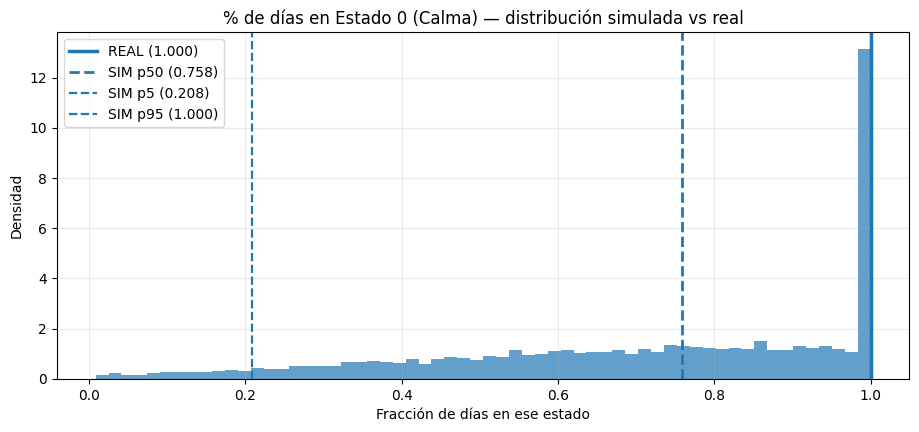

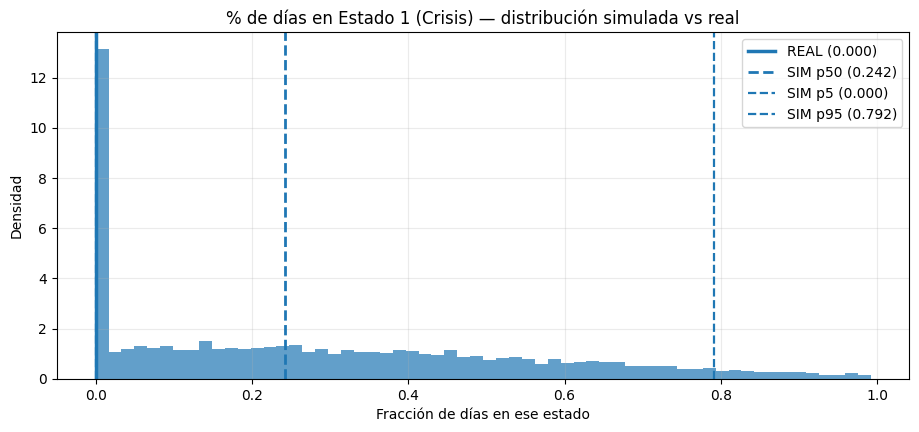

In [409]:
# -----------------------------
# 2) GRÁFICO A: % días en cada estado (dist sim + línea real)
# -----------------------------

for st in states:
    x = pct_sim_paths[st]
    p5, p50, p95 = qsum(x)

    plt.figure(figsize=(11, 4.5))
    plt.hist(x, bins=60, density=True, alpha=0.7)
    plt.axvline(pct_real[st], linewidth=2.5, label=f"REAL ({pct_real[st]:.3f})")
    plt.axvline(p50, linestyle="--", linewidth=2.0, label=f"SIM p50 ({p50:.3f})")
    plt.axvline(p5, linestyle="--", linewidth=1.6, label=f"SIM p5 ({p5:.3f})")
    plt.axvline(p95, linestyle="--", linewidth=1.6, label=f"SIM p95 ({p95:.3f})")
    plt.title(f"% de días en {label(st)} — distribución simulada vs real")
    plt.xlabel("Fracción de días en ese estado")
    plt.ylabel("Densidad")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()


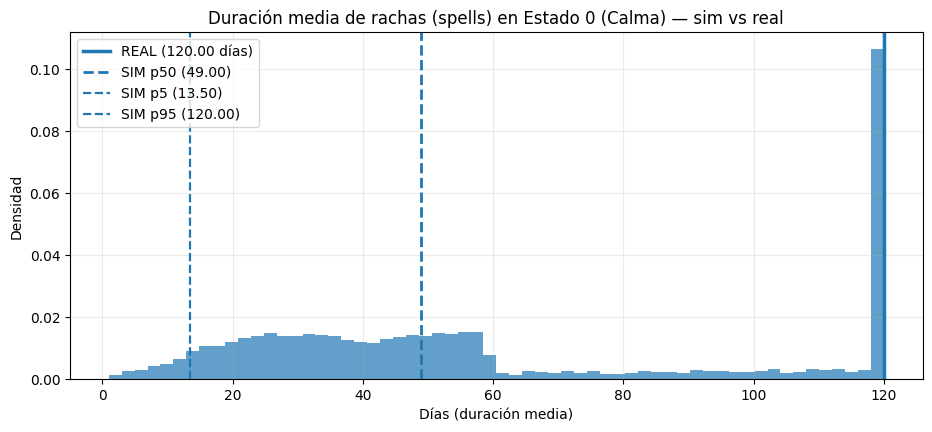

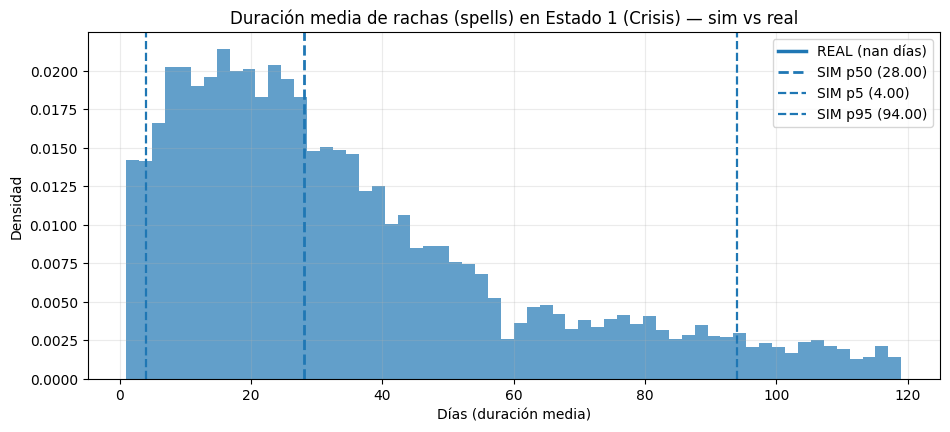

In [410]:

# -----------------------------
# 3) GRÁFICO B: Duración media de spells por estado
# -----------------------------
for st in states:
    x = dur_sim_paths[st]
    x = x[np.isfinite(x)]
    p5, p50, p95 = qsum(x)

    plt.figure(figsize=(11, 4.5))
    plt.hist(x, bins=60, density=True, alpha=0.7)
    plt.axvline(dur_real[st], linewidth=2.5, label=f"REAL ({dur_real[st]:.2f} días)")
    plt.axvline(p50, linestyle="--", linewidth=2.0, label=f"SIM p50 ({p50:.2f})")
    plt.axvline(p5, linestyle="--", linewidth=1.6, label=f"SIM p5 ({p5:.2f})")
    plt.axvline(p95, linestyle="--", linewidth=1.6, label=f"SIM p95 ({p95:.2f})")
    plt.title(f"Duración media de rachas (spells) en {label(st)} — sim vs real")
    plt.xlabel("Días (duración media)")
    plt.ylabel("Densidad")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

Observamos que en la simulacion tenemos:
* En el percentil 5: varios momentos de crisis
* En el percentil 50: Los estados empiezan a asemejarse a lo que encontramos en la realidad -> más días de calma
* En el percentil 95: Es totalmente similar a la realidad.

Los 6 meses elegidos representan un escenario real de calma, por lo que nuestras simulaciones tienden a representar este estado y, aunque podemos encontrar días de crisis (especialmente al principio de las simulaciones), al final obtenemos un resultado muy próximo a la realidad (todo calma).

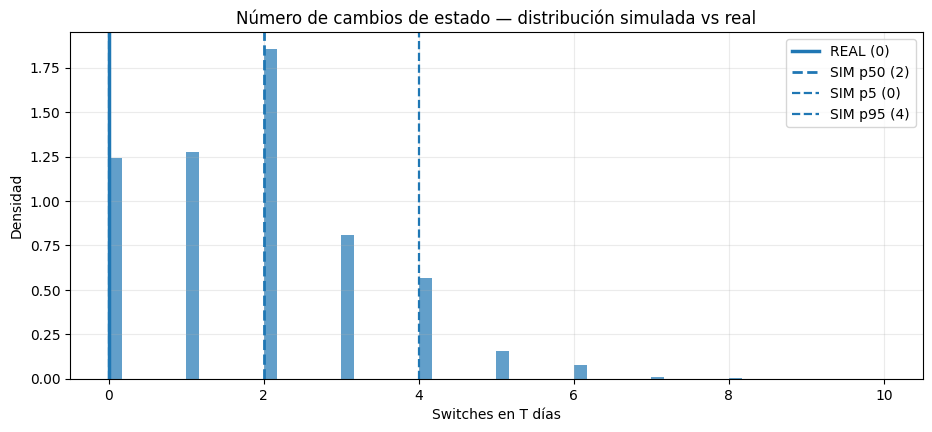

In [411]:
# -----------------------------
# 4) GRÁFICO C: Nº cambios de estado (switches)
# -----------------------------
p5, p50, p95 = qsum(sw_sim_paths)

plt.figure(figsize=(11, 4.5))
plt.hist(sw_sim_paths, bins=60, density=True, alpha=0.7)
plt.axvline(sw_real, linewidth=2.5, label=f"REAL ({sw_real})")
plt.axvline(p50, linestyle="--", linewidth=2.0, label=f"SIM p50 ({p50:.0f})")
plt.axvline(p5, linestyle="--", linewidth=1.6, label=f"SIM p5 ({p5:.0f})")
plt.axvline(p95, linestyle="--", linewidth=1.6, label=f"SIM p95 ({p95:.0f})")
plt.title("Número de cambios de estado — distribución simulada vs real")
plt.xlabel("Switches en T días")
plt.ylabel("Densidad")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


In [413]:

# -----------------------------
# 1) Funciones de métricas
# -----------------------------
def max_drawdown_from_returns(r: np.ndarray) -> float:
    """MDD sobre wealth (base 1) a partir de retornos aritméticos diarios."""
    r = np.asarray(r, dtype=float)
    w = np.empty(r.size + 1)
    w[0] = 1.0
    w[1:] = np.cumprod(1.0 + r)
    peak = np.maximum.accumulate(w)
    dd = (w / peak) - 1.0
    return float(dd.min())  # negativo (ej. -0.12 = -12%)

def var_es(r: np.ndarray, alpha: float = 0.01):
    """VaR y ES como pérdidas POSITIVAS. alpha=0.01 => VaR99/ES99."""
    r = np.asarray(r, dtype=float)
    q = np.quantile(r, alpha)
    var = -q
    es = -r[r <= q].mean() if np.any(r <= q) else np.nan
    return float(var), float(es), float(q)

def summarize(x: np.ndarray):
    x = np.asarray(x, dtype=float)
    return {
        "mean": float(np.nanmean(x)),
        "p5":  float(np.nanpercentile(x, 5)),
        "p50": float(np.nanpercentile(x, 50)),
        "p95": float(np.nanpercentile(x, 95)),
    }


In [414]:
# ============================================================
# Reproducción de riesgo y dependencia (REAL vs SIM) + checks estrés
# ============================================================

# -----------------------------
# 2) Métricas de cartera: REAL
# -----------------------------
vol_d_real = float(np.std(windowed_daily_percentage_returns, ddof=1))
vol_a_real = vol_d_real * np.sqrt(252)
mdd_real = max_drawdown_from_returns(windowed_daily_percentage_returns)
var99_real, es99_real, q01_real = var_es(windowed_daily_percentage_returns, alpha=0.01)

# -----------------------------
# 3) Métricas de cartera: SIM (por trayectoria)
# -----------------------------
vol_d_sim = np.std(simulated_returns_percentages, axis=1, ddof=1)
vol_a_sim = vol_d_sim * np.sqrt(252)

# MDD por trayectoria (vectorizado)
simulated_wealth = np.empty((N_PATHS, window_size + 1), dtype=float)
simulated_wealth[:,0] = 1.0
simulated_wealth[:, 1:] = np.cumprod(1.0 + simulated_returns_percentages, axis=1)

peak = np.maximum.accumulate(simulated_wealth, axis=1)
dd = simulated_wealth / peak - 1.0
mdd_sim = dd.min(axis=1)  # negativo

# VaR/ES por trayectoria
q01_sim = np.quantile(simulated_returns_percentages, 0.01, axis=1)
var99_sim = -q01_sim
es99_sim = np.empty(N_PATHS, dtype=float)
for i in range(N_PATHS):
    mask = simulated_returns_percentages[i] <= q01_sim[i]
    es99_sim[i] = -simulated_returns_percentages[i, mask].mean() if np.any(mask) else np.nan

# Resumen
summary_tbl = pd.DataFrame({
    "REAL": [vol_d_real, vol_a_real, mdd_real, var99_real, es99_real],
    "SIM mean": [summarize(vol_d_sim)["mean"], summarize(vol_a_sim)["mean"], summarize(mdd_sim)["mean"],
                 summarize(var99_sim)["mean"], summarize(es99_sim)["mean"]],
    "SIM p5": [summarize(vol_d_sim)["p5"], summarize(vol_a_sim)["p5"], summarize(mdd_sim)["p5"],
               summarize(var99_sim)["p5"], summarize(es99_sim)["p5"]],
    "SIM p50": [summarize(vol_d_sim)["p50"], summarize(vol_a_sim)["p50"], summarize(mdd_sim)["p50"],
                summarize(var99_sim)["p50"], summarize(es99_sim)["p50"]],
    "SIM p95": [summarize(vol_d_sim)["p95"], summarize(vol_a_sim)["p95"], summarize(mdd_sim)["p95"],
                summarize(var99_sim)["p95"], summarize(es99_sim)["p95"]],
}, index=["Vol diaria","Vol anualizada","Max Drawdown","VaR 99% (loss)","ES 99% (loss)"])

display(summary_tbl)

,REAL,SIM mean,SIM p5,SIM p50,SIM p95
Vol diaria,0.006247,0.010087,0.006729,0.009845,0.014291
Vol anualizada,0.099162,0.160131,0.106817,0.156286,0.226861
Max Drawdown,-0.035277,-0.090556,-0.186791,-0.078677,-0.034904
VaR 99% (loss),0.017059,0.023786,0.012921,0.022770,0.038313
ES 99% (loss),0.018867,0.028801,0.014980,0.027421,0.047540


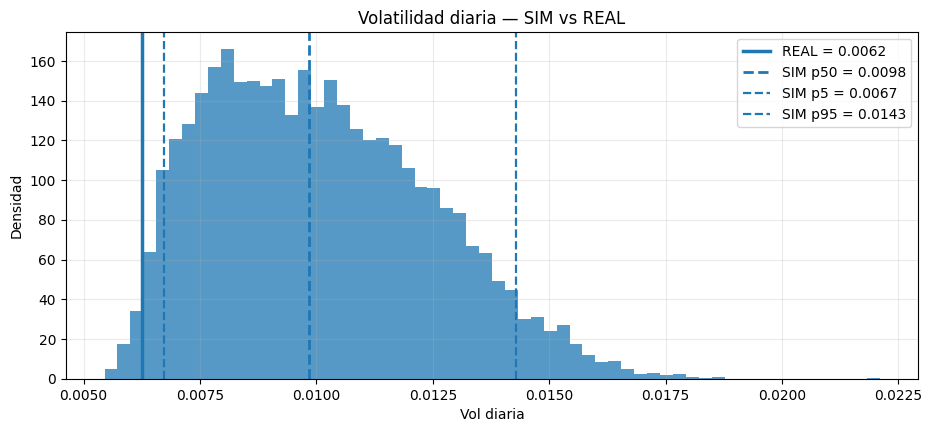

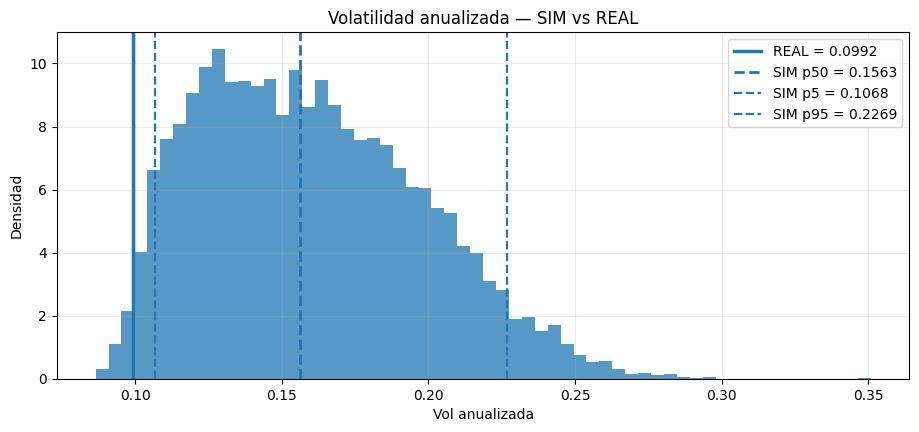

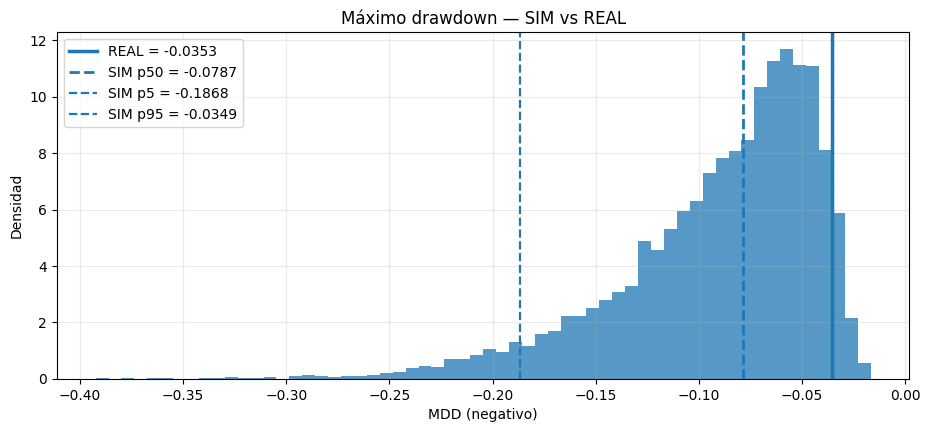

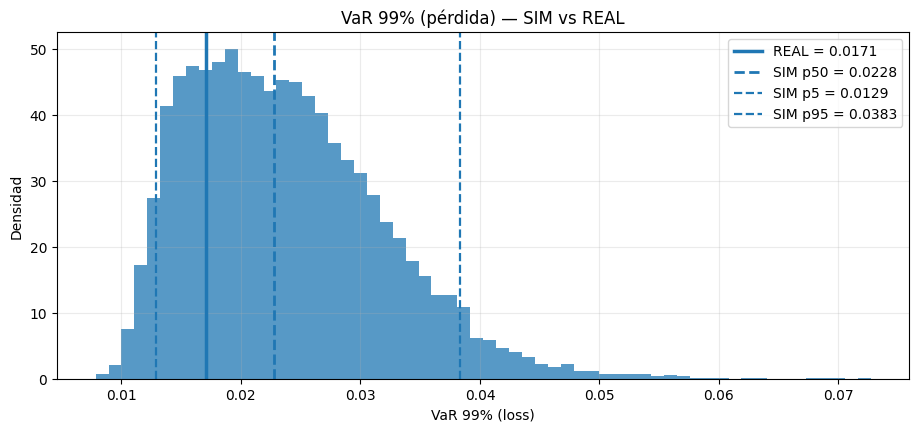

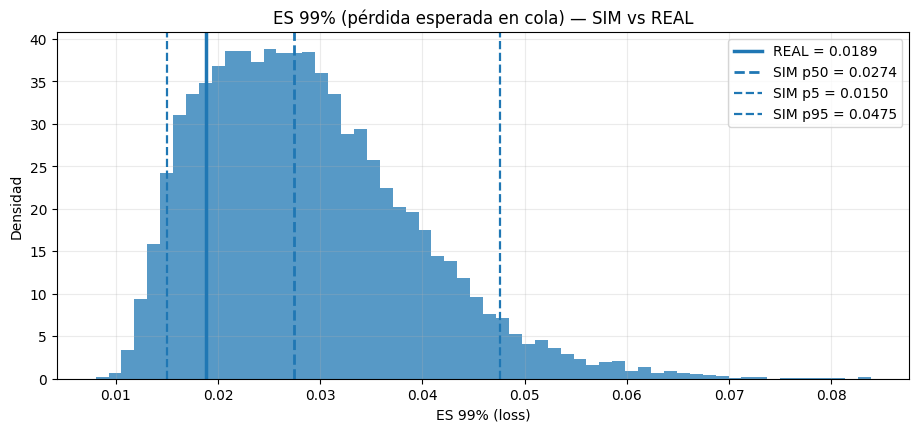

In [415]:

# -----------------------------
# 4) Gráficos: distribución métricas SIM + línea REAL
# -----------------------------
def hist_compare(x, x_real, title, xlabel):
    x = np.asarray(x, float)
    plt.figure(figsize=(11,4.5))
    plt.hist(x, bins=60, density=True, alpha=0.75)
    plt.axvline(x_real, linewidth=2.5, label=f"REAL = {x_real:.4f}")
    p5,p50,p95 = np.percentile(x[np.isfinite(x)], [5,50,95])
    plt.axvline(p50, linestyle="--", linewidth=2.0, label=f"SIM p50 = {p50:.4f}")
    plt.axvline(p5,  linestyle="--", linewidth=1.6, label=f"SIM p5 = {p5:.4f}")
    plt.axvline(p95, linestyle="--", linewidth=1.6, label=f"SIM p95 = {p95:.4f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Densidad")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

hist_compare(vol_d_sim, vol_d_real, "Volatilidad diaria — SIM vs REAL", "Vol diaria")
hist_compare(vol_a_sim, vol_a_real, "Volatilidad anualizada — SIM vs REAL", "Vol anualizada")
hist_compare(mdd_sim, mdd_real, "Máximo drawdown — SIM vs REAL", "MDD (negativo)")
hist_compare(var99_sim, var99_real, "VaR 99% (pérdida) — SIM vs REAL", "VaR 99% (loss)")
hist_compare(es99_sim, es99_real, "ES 99% (pérdida esperada en cola) — SIM vs REAL", "ES 99% (loss)")

In [416]:

# ============================================================
# 5) CHECKS de ESTRÉS: ¿sube vol? ¿cambian correlaciones? ¿más extremos?
#   REAL: por estados del HMM en el histórico completo
#   SIM : recalculamos stats por estado usando la misma cópula+marginales,
#         siguiendo la secuencia de estados S (sin guardar todo en memoria).
# ============================================================

# ----- REAL por estado (histórico completo) -----
logR_all = wallet_returns.dropna(how="any")
states_all = wallet_crisis_prediction.reindex(logR_all.index, method="ffill").astype(int).values

calm_state = int(np.min([s for s in np.unique(states_all) if s != crisis_state])) if len(np.unique(states_all)) > 1 else 1-crisis_state

logR_calm = logR_all.iloc[states_all == calm_state].values
logR_cris = logR_all.iloc[states_all == crisis_state].values

arith_calm = np.expm1(logR_calm)
arith_cris = np.expm1(logR_cris)

vol_real_calm = np.std(arith_calm, axis=0, ddof=1)
vol_real_cris = np.std(arith_cris, axis=0, ddof=1)

corr_real_calm = np.corrcoef(arith_calm, rowvar=False)
corr_real_cris = np.corrcoef(arith_cris, rowvar=False)

def mean_offdiag(C):
    C = np.asarray(C, float)
    iu = np.triu_indices_from(C, k=1)
    return float(np.nanmean(C[iu]))

mean_corr_real_calm = mean_offdiag(corr_real_calm)
mean_corr_real_cris = mean_offdiag(corr_real_cris)

# co-movimientos extremos: nº medio de activos por día por debajo del 1% (por estado)
q1_real_calm = np.quantile(arith_calm, 0.01, axis=0)
q1_real_cris = np.quantile(arith_cris, 0.01, axis=0)
ext_real_calm = float((arith_calm <= q1_real_calm).sum(axis=1).mean()) if arith_calm.size else np.nan
ext_real_cris = float((arith_cris <= q1_real_cris).sum(axis=1).mean()) if arith_cris.size else np.nan

# ----- SIM por estado (re-sample eficiente siguiendo S) -----
# Marginales empíricas (log-returns) por estado para inverse-CDF
if "wallet_calm_returns" in globals() and "wallet_crisis_returns" in globals():
    calm_data = wallet_calm_returns.dropna(how="any").values
    cris_data = wallet_crisis_returns.dropna(how="any").values
else:
    calm_data = logR_all.iloc[states_all == calm_state].values
    cris_data = logR_all.iloc[states_all == crisis_state].values

calm_lookup = np.sort(calm_data, axis=0)
crisis_lookup = np.sort(cris_data, axis=0)

def inv_ecdf(U: np.ndarray, sorted_vals: np.ndarray) -> np.ndarray:
    """Inverse empirical CDF via sorted columns (linear interp)."""
    n = sorted_vals.shape[0]
    x = U * (n - 1)
    i0 = np.floor(x).astype(int)
    i1 = np.minimum(i0 + 1, n - 1)
    w = x - i0
    v0 = np.take_along_axis(sorted_vals, i0, axis=0)
    v1 = np.take_along_axis(sorted_vals, i1, axis=0)
    return v0 + (v1 - v0) * w

import scipy.stats as sps  # <-- usa otro alias para no pisarlo

def sample_t_copula_U(m, Rho, nu, rng):
    """Muestrea U de una t-cópula (usa `k` global)."""
    Rho = np.asarray(Rho, float)
    L = np.linalg.cholesky(Rho)

    # usa k global (definido antes como len(assets))
    g = rng.standard_normal((m, k)) @ L.T
    w = rng.chisquare(df=nu, size=m)
    z = g / np.sqrt(w[:, None] / nu)

    U = sps.t.cdf(z, df=nu)
    eps = 1e-12
    return np.clip(U, eps, 1 - eps)

random_generator = np.random.default_rng(globals().get("SEED", 123))

# Agregadores por estado para media/cov
agg = {
    calm_state: {"n":0, "sum":np.zeros(n_tickers), "sumsq":np.zeros(n_tickers), "sumouter":np.zeros((n_tickers,n_tickers)),
                "ext_hits":0.0, "obs":0},
    crisis_state: {"n":0, "sum":np.zeros(n_tickers), "sumsq":np.zeros(n_tickers), "sumouter":np.zeros((n_tickers,n_tickers)),
                   "ext_hits":0.0, "obs":0},
}

# thresholds de extremos en SIM: usar los q1 reales por estado (comparación coherente)
q1_sim_calm = q1_real_calm
q1_sim_cris = q1_real_cris

for t in range(window_size):
    s_t = all_simulation_states[:, t]
    for st_ in [calm_state, crisis_state]:
        idx = np.where(s_t == st_)[0]
        m = idx.size
        if m == 0:
            continue

        if st_ == crisis_state:
            nu = int(crisis_nu); Rho = nu_crisis_corr; sorted_vals = crisis_lookup; q1 = q1_sim_cris
        else:
            nu = int(calm_nu);   Rho = nu_calm_corr;   sorted_vals = calm_lookup; q1 = q1_sim_calm

        U = sample_t_copula_U(m, Rho, nu, random_generator)                 # (m,k)
        logR = inv_ecdf(U, sorted_vals)                        # (m,k) log-returns
        arR  = np.expm1(logR)                                  # (m,k) arithmetic

        A = agg[st_]
        A["n"] += m
        A["sum"] += arR.sum(axis=0)
        A["sumsq"] += (arR**2).sum(axis=0)
        A["sumouter"] += arR.T @ arR

        # extremos: nº medio de activos por observación que caen bajo q1
        A["ext_hits"] += float((arR <= q1).sum())  # cuenta total de "hits" (obs*assets)
        A["obs"] += m

def finalize_state(A):
    n = A["n"]
    mu = A["sum"] / n
    cov = (A["sumouter"] / n) - np.outer(mu, mu)
    sd = np.sqrt(np.clip(np.diag(cov), 1e-18, None))
    corr = cov / np.outer(sd, sd)
    vol = sd
    mean_corr = mean_offdiag(corr)
    ext_avg_assets = A["ext_hits"] / A["obs"] if A["obs"] > 0 else np.nan
    return mu, vol, corr, mean_corr, ext_avg_assets

mu_sim_calm, vol_sim_calm, corr_sim_calm, mean_corr_sim_calm, ext_sim_calm = finalize_state(agg[calm_state])
mu_sim_cris, vol_sim_cris, corr_sim_cris, mean_corr_sim_cris, ext_sim_cris = finalize_state(agg[crisis_state])

# ----- Report resumen estrés -----
stress_tbl = pd.DataFrame({
    "REAL calm": [float(np.mean(vol_real_calm)), mean_corr_real_calm, ext_real_calm],
    "REAL crisis": [float(np.mean(vol_real_cris)), mean_corr_real_cris, ext_real_cris],
    "SIM calm": [float(np.mean(vol_sim_calm)), mean_corr_sim_calm, ext_sim_calm],
    "SIM crisis": [float(np.mean(vol_sim_cris)), mean_corr_sim_cris, ext_sim_cris],
}, index=["Vol media activos (diaria)","Correlación media offdiag","Extremos: #activos bajo q1 (prom.)"])

display(stress_tbl)

NameError: name 'k' is not defined

In [307]:

# Ratios crisis/calma (deberían ser >1 en vol y normalmente subir corr/colas)
ratio_tbl = pd.DataFrame({
    "REAL crisis/calm": [
        float(np.mean(vol_real_cris) / np.mean(vol_real_calm)),
        float(mean_corr_real_cris - mean_corr_real_calm),
        float(ext_real_cris - ext_real_calm)
    ],
    "SIM crisis/calm": [
        float(np.mean(vol_sim_cris) / np.mean(vol_sim_calm)),
        float(mean_corr_sim_cris - mean_corr_sim_calm),
        float(ext_sim_cris - ext_sim_calm)
    ]
}, index=["Vol ratio","Δ Corr media (crisis-calm)","Δ Extremos (# activos)"])

display(ratio_tbl)

,REAL crisis/calm,SIM crisis/calm
Vol ratio,1.435774,1.440267
Δ Corr media (crisis-calm),0.183125,0.151638
Δ Extremos (# activos),0.014977,0.000932


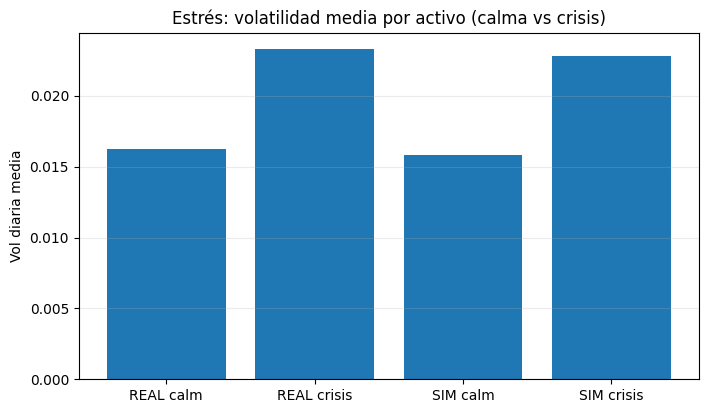

In [308]:
# ----- Gráficos estrés (fáciles de leer) -----
# 1) Vol media por estado
plt.figure(figsize=(8,4.5))
plt.bar(["REAL calm","REAL crisis","SIM calm","SIM crisis"],
        [np.mean(vol_real_calm), np.mean(vol_real_cris), np.mean(vol_sim_calm), np.mean(vol_sim_cris)])
plt.title("Estrés: volatilidad media por activo (calma vs crisis)")
plt.ylabel("Vol diaria media")
plt.grid(True, axis="y", alpha=0.25)
plt.show()

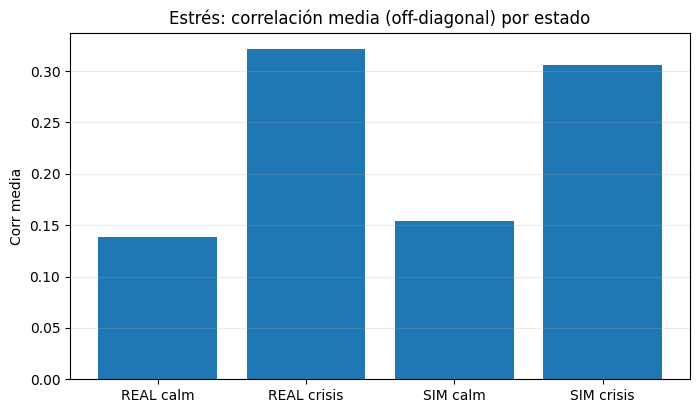

In [309]:
# 2) Corr media offdiag
plt.figure(figsize=(8,4.5))
plt.bar(["REAL calm","REAL crisis","SIM calm","SIM crisis"],
        [mean_corr_real_calm, mean_corr_real_cris, mean_corr_sim_calm, mean_corr_sim_cris])
plt.title("Estrés: correlación media (off-diagonal) por estado")
plt.ylabel("Corr media")
plt.grid(True, axis="y", alpha=0.25)
plt.show()

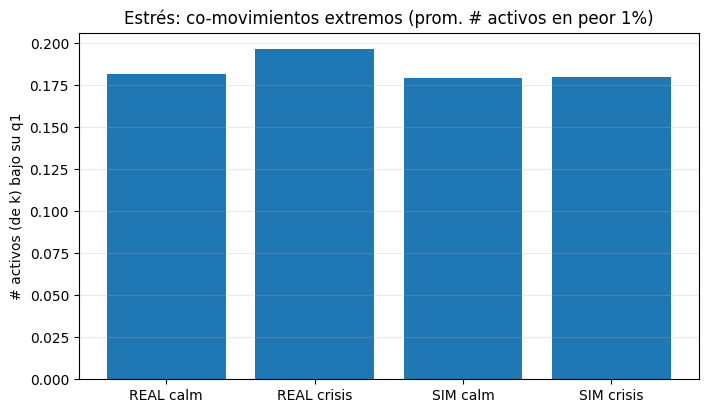

In [310]:
# 3) Co-movimientos extremos
plt.figure(figsize=(8,4.5))
plt.bar(["REAL calm","REAL crisis","SIM calm","SIM crisis"],
        [ext_real_calm, ext_real_cris, ext_sim_calm, ext_sim_cris])
plt.title("Estrés: co-movimientos extremos (prom. # activos en peor 1%)")
plt.ylabel("# activos (de k) bajo su q1")
plt.grid(True, axis="y", alpha=0.25)
plt.show()
